# Imports

In [1]:
from utils.imports import *
from utils.data_loader import download_data, load_data
from utils.models import PretrainedModel, AlexNetVanilla
from utils.utils import preprocess_images, get_current_time, calculate_pca, apply_pca_to_rois
from utils.config import batch_size, num_epochs, model_str

# Initialize data

In [2]:
fnames = ["../kay_labels.npy", "../kay_labels_val.npy", "../kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

if download_data(fnames, urls):
    init_training_inputs, init_test_inputs, training_outputs, test_outputs, roi, roi_names, labels, val_labels = load_data('../kay_images.npz')

In [3]:
# Preprocess the images
training_inputs = preprocess_images(init_training_inputs)
test_inputs = preprocess_images(init_test_inputs)

# Testing

## Testing setup

In [4]:
test_pca, _ = calculate_pca(test_outputs)
roi_pca_test = apply_pca_to_rois(test_outputs, roi)

In [5]:
# Try model predicting data from a dataloader
def predicted_actual_values(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = []
    all_actual = []
    model.eval()
    with torch.no_grad():
        for data, targets in dataloader:
            # Ensure data is on the same device as the model
            data = data.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            outputs, _ = model.forward_with_intermediate(data)
            all_preds.extend(outputs.cpu().numpy())
            all_actual.extend(targets.cpu().numpy())

    return np.array(all_preds), np.array(all_actual)

# Compute Root Mean Squared Error
def compute_rmse(predictions, actual):
    rmse = mean_squared_error(actual, predictions, squared=False)
    return rmse

# Compute R-squared (Coefficient of Determination)
def compute_r2_score(predictions, actual):
    r2 = r2_score(actual, predictions)
    return r2

# Compute Pearson Correlation Coefficient
def compute_pearson_correlation(predictions, actual):
    # Flatten the predictions and actual arrays in case they have more than one dimension
    predictions_flat = predictions.flatten()
    actual_flat = actual.flatten()
    correlation, _ = pearsonr(predictions_flat, actual_flat)
    return correlation

# Try running trained model on test data
def test_trained_model(model, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    #x_test = reshaped_gabor
    x_test = test_inputs
    #y_test = roi_pca_test
    y_test = test_pca
    #y_test = test_outputs

    # Create tensor from training inputs and targets
    x_test_tensor, y_test_tensor = torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float()
    test_data_tensor = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
    # Create dataloader from tensor
    test_dataloader = torch.utils.data.DataLoader(test_data_tensor, batch_size, shuffle=True)
    
    # Compute accuracy of model predictions
    predicted_results, actual_results = predicted_actual_values(model, test_dataloader)
    print('Predictions:')
    print(predicted_results[0][0:10])
    print('Actual:')
    print(actual_results[0][0:10])

    rmse = compute_rmse(predicted_results, actual_results)
    r2 = compute_r2_score(predicted_results, actual_results)
    pearson_correlation = compute_pearson_correlation(predicted_results, actual_results)
    
    print(f'Achieved RMSE: {rmse:.2f}')
    print(f'R-squared: {r2:.2f}')
    print(f'Pearson Correlation Coefficient: {pearson_correlation:.2f}')

In [6]:
# Load model
print('Input training shape:', training_inputs.shape)
#print(reduce_outputs_to_ROIs(training_outputs).shape)
print('Input test shape:', test_inputs.shape)
#print(reduce_outputs_to_ROIs(test_outputs).shape)


model = PretrainedModel(model_str, 10, 0.85) # Change model_str if you are testing a different model than the one training
print('Model loaded:', model_str)

model.load_state_dict(torch.load('../trained_models/AlexNet_val_model_01_01_24_13_58_04.pth'))

# Test model
test_trained_model(model=model, batch_size=batch_size)

Input training shape: (1750, 3, 224, 224)
Input test shape: (120, 3, 224, 224)
Model loaded: AlexNet
Predictions:
[ 9.21289437e-03 -2.06008554e-05  6.21383972e-02  7.89321288e-02
 -1.96836460e-02  8.82069543e-02 -2.57560164e-02  2.59484630e-02
 -4.66350503e-02  1.47912055e-02]
Actual:
[  5.8168797   0.6972417   5.3696017  -4.0450654  -1.46338     2.735274
  21.112772  -12.046881    5.2232347  -7.3435273]
Achieved RMSE: 10.23
R-squared: 0.00
Pearson Correlation Coefficient: 0.19


# NOTES FROM EXPERMENTING

3 droputs of 0.9 seemed to be promising but stagnated

3 dropouts of 0.85 stagnated after crossing 

3 dopouts of 0.75


Next time, try between 0.75 and 0.85
otherwise between 0.85 and 0.9

Implement feature layer output saved as pickle file to run model faster

Try with another dateset to confirm wehter it is just a "lorte dataset"

Save every 10 epoch as well as the best

**Evaluation metrics**

1. **RMSE**: Root Mean Squared Error is the square root of the mean of the squared errors. The RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction. A lower RMSE is better as it indicates a closer fit of the model to the data.
2. **R2**: R-squared values typically range from 0 to 1 and can be interpreted as the proportion of the variance in the dependent variable that is predictable from the independent variables. Negative values of R-squared indicate that the model fits the data worse than a horizontal hyperplane at the mean of the dependent variable. This suggests that the model is not capturing the variance of the data well and is performing poorly on this task. It could be due to an overfitted model, a wrong model choice, or irrelevant features.
3. **Pearson correlation**: Pearson correlation coefficient measures the linear correlation between two variables. The coefficient values range between -1 and 1. A value close to 1 implies that there is a strong positive correlation between the two variables. A value close to -1 implies that there is a strong negative correlation between the two variables. A value close to 0 implies that there is no linear correlation between the two variables.


## Visualize intermediate outputs

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_test_tensor = torch.from_numpy(test_inputs).float()

x_test_tensor = x_test_tensor.to(device)
final_output, intermediate_outputs = model.forward_with_intermediate(x_test_tensor)

y_test_tensor = torch.from_numpy(test_outputs).float()

# test_data_tensor = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

print(intermediate_outputs.keys())

print(intermediate_outputs['features_0'].shape)

#print(intermediate_outputs['features_0'][6])

dict_keys(['features_0', 'features_1', 'features_2', 'features_3', 'features_4', 'features_5', 'features_6', 'features_7', 'features_8', 'features_9', 'features_10', 'features_11', 'features_12', 'classifier_0', 'classifier_1', 'classifier_2', 'classifier_3', 'classifier_4', 'classifier_5', 'classifier_6', 'classifier_7'])
torch.Size([120, 64, 55, 55])


Number of layers: 21


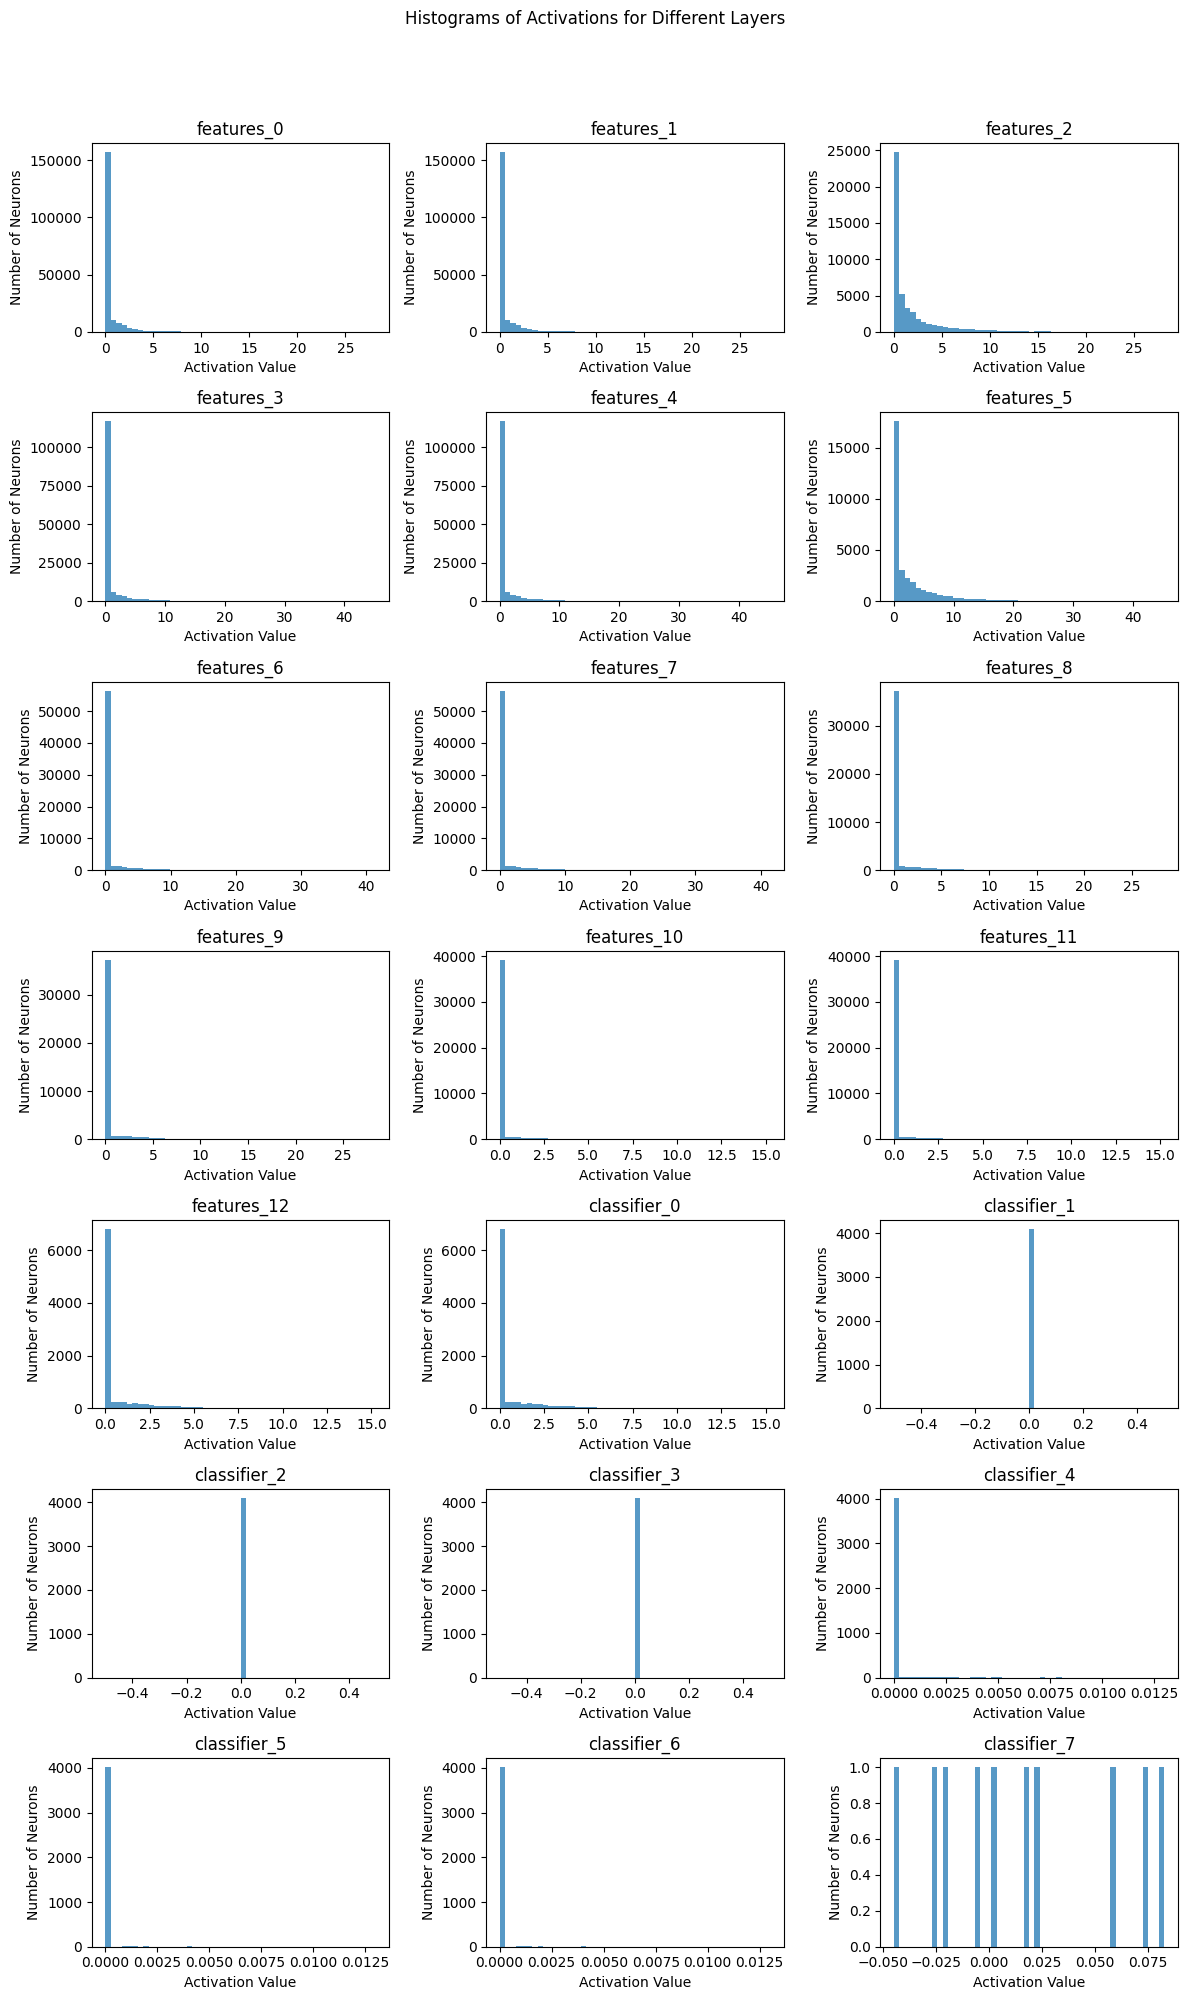

In [14]:
# Number of layers to visualize
num_layers = len(intermediate_outputs)
print(f'Number of layers: {num_layers}')

# Sample index to visualize
sample_index = 6

# Define the layout for the subplots
cols = 3  # Number of columns
rows = -(-num_layers // cols)  # Ceiling division to determine the number of rows

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
fig.suptitle('Histograms of Activations for Different Layers')

# Flatten axes array for easy indexing
axes = axes.flatten()

# Iterate through each layer
for i, (layer_name, activations) in enumerate(intermediate_outputs.items()):
    # Check if the current batch has the sample_index
    if activations.shape[0] > sample_index:
        # Prepare the activation values
        activation_values = activations[sample_index].detach().cpu().numpy().flatten()

        # Plot the histogram in the corresponding subplot
        axes[i].hist(activation_values, bins=50, alpha=0.75)
        axes[i].set_title(f'{layer_name}')
        axes[i].set_xlabel('Activation Value')
        axes[i].set_ylabel('Number of Neurons')

# Hide unused subplots
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

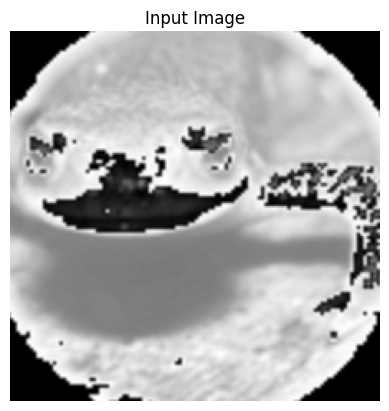

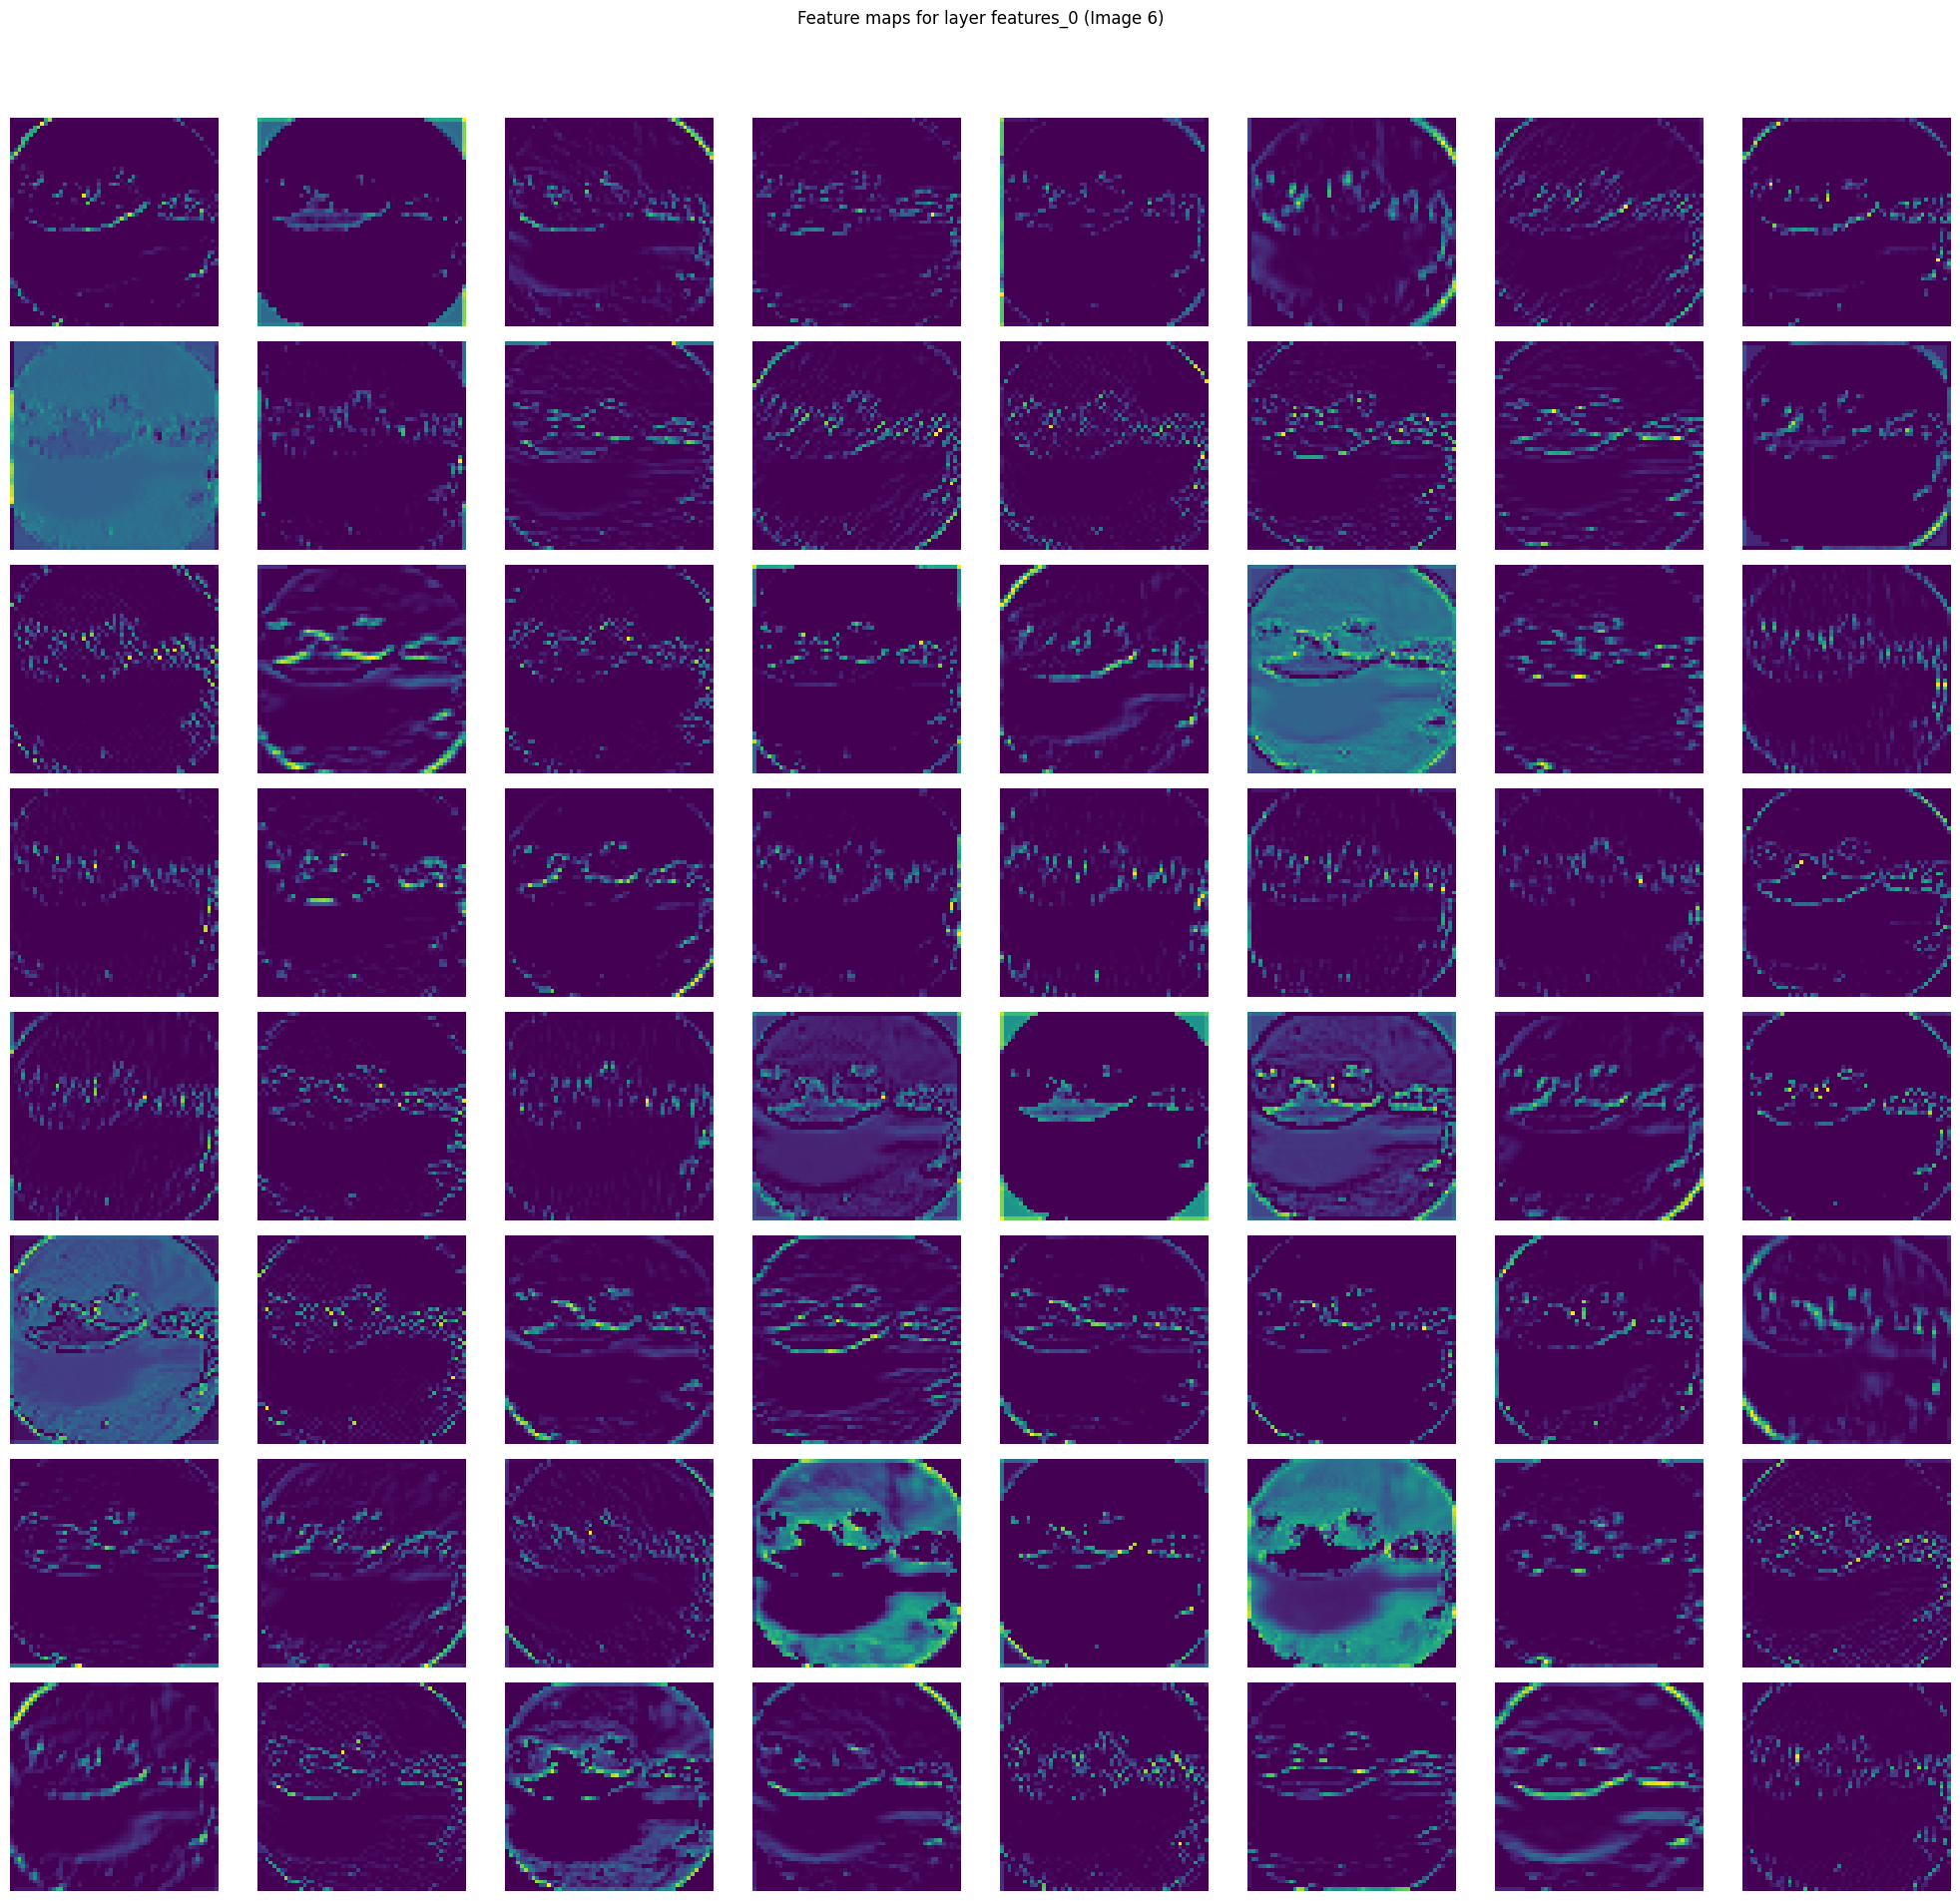

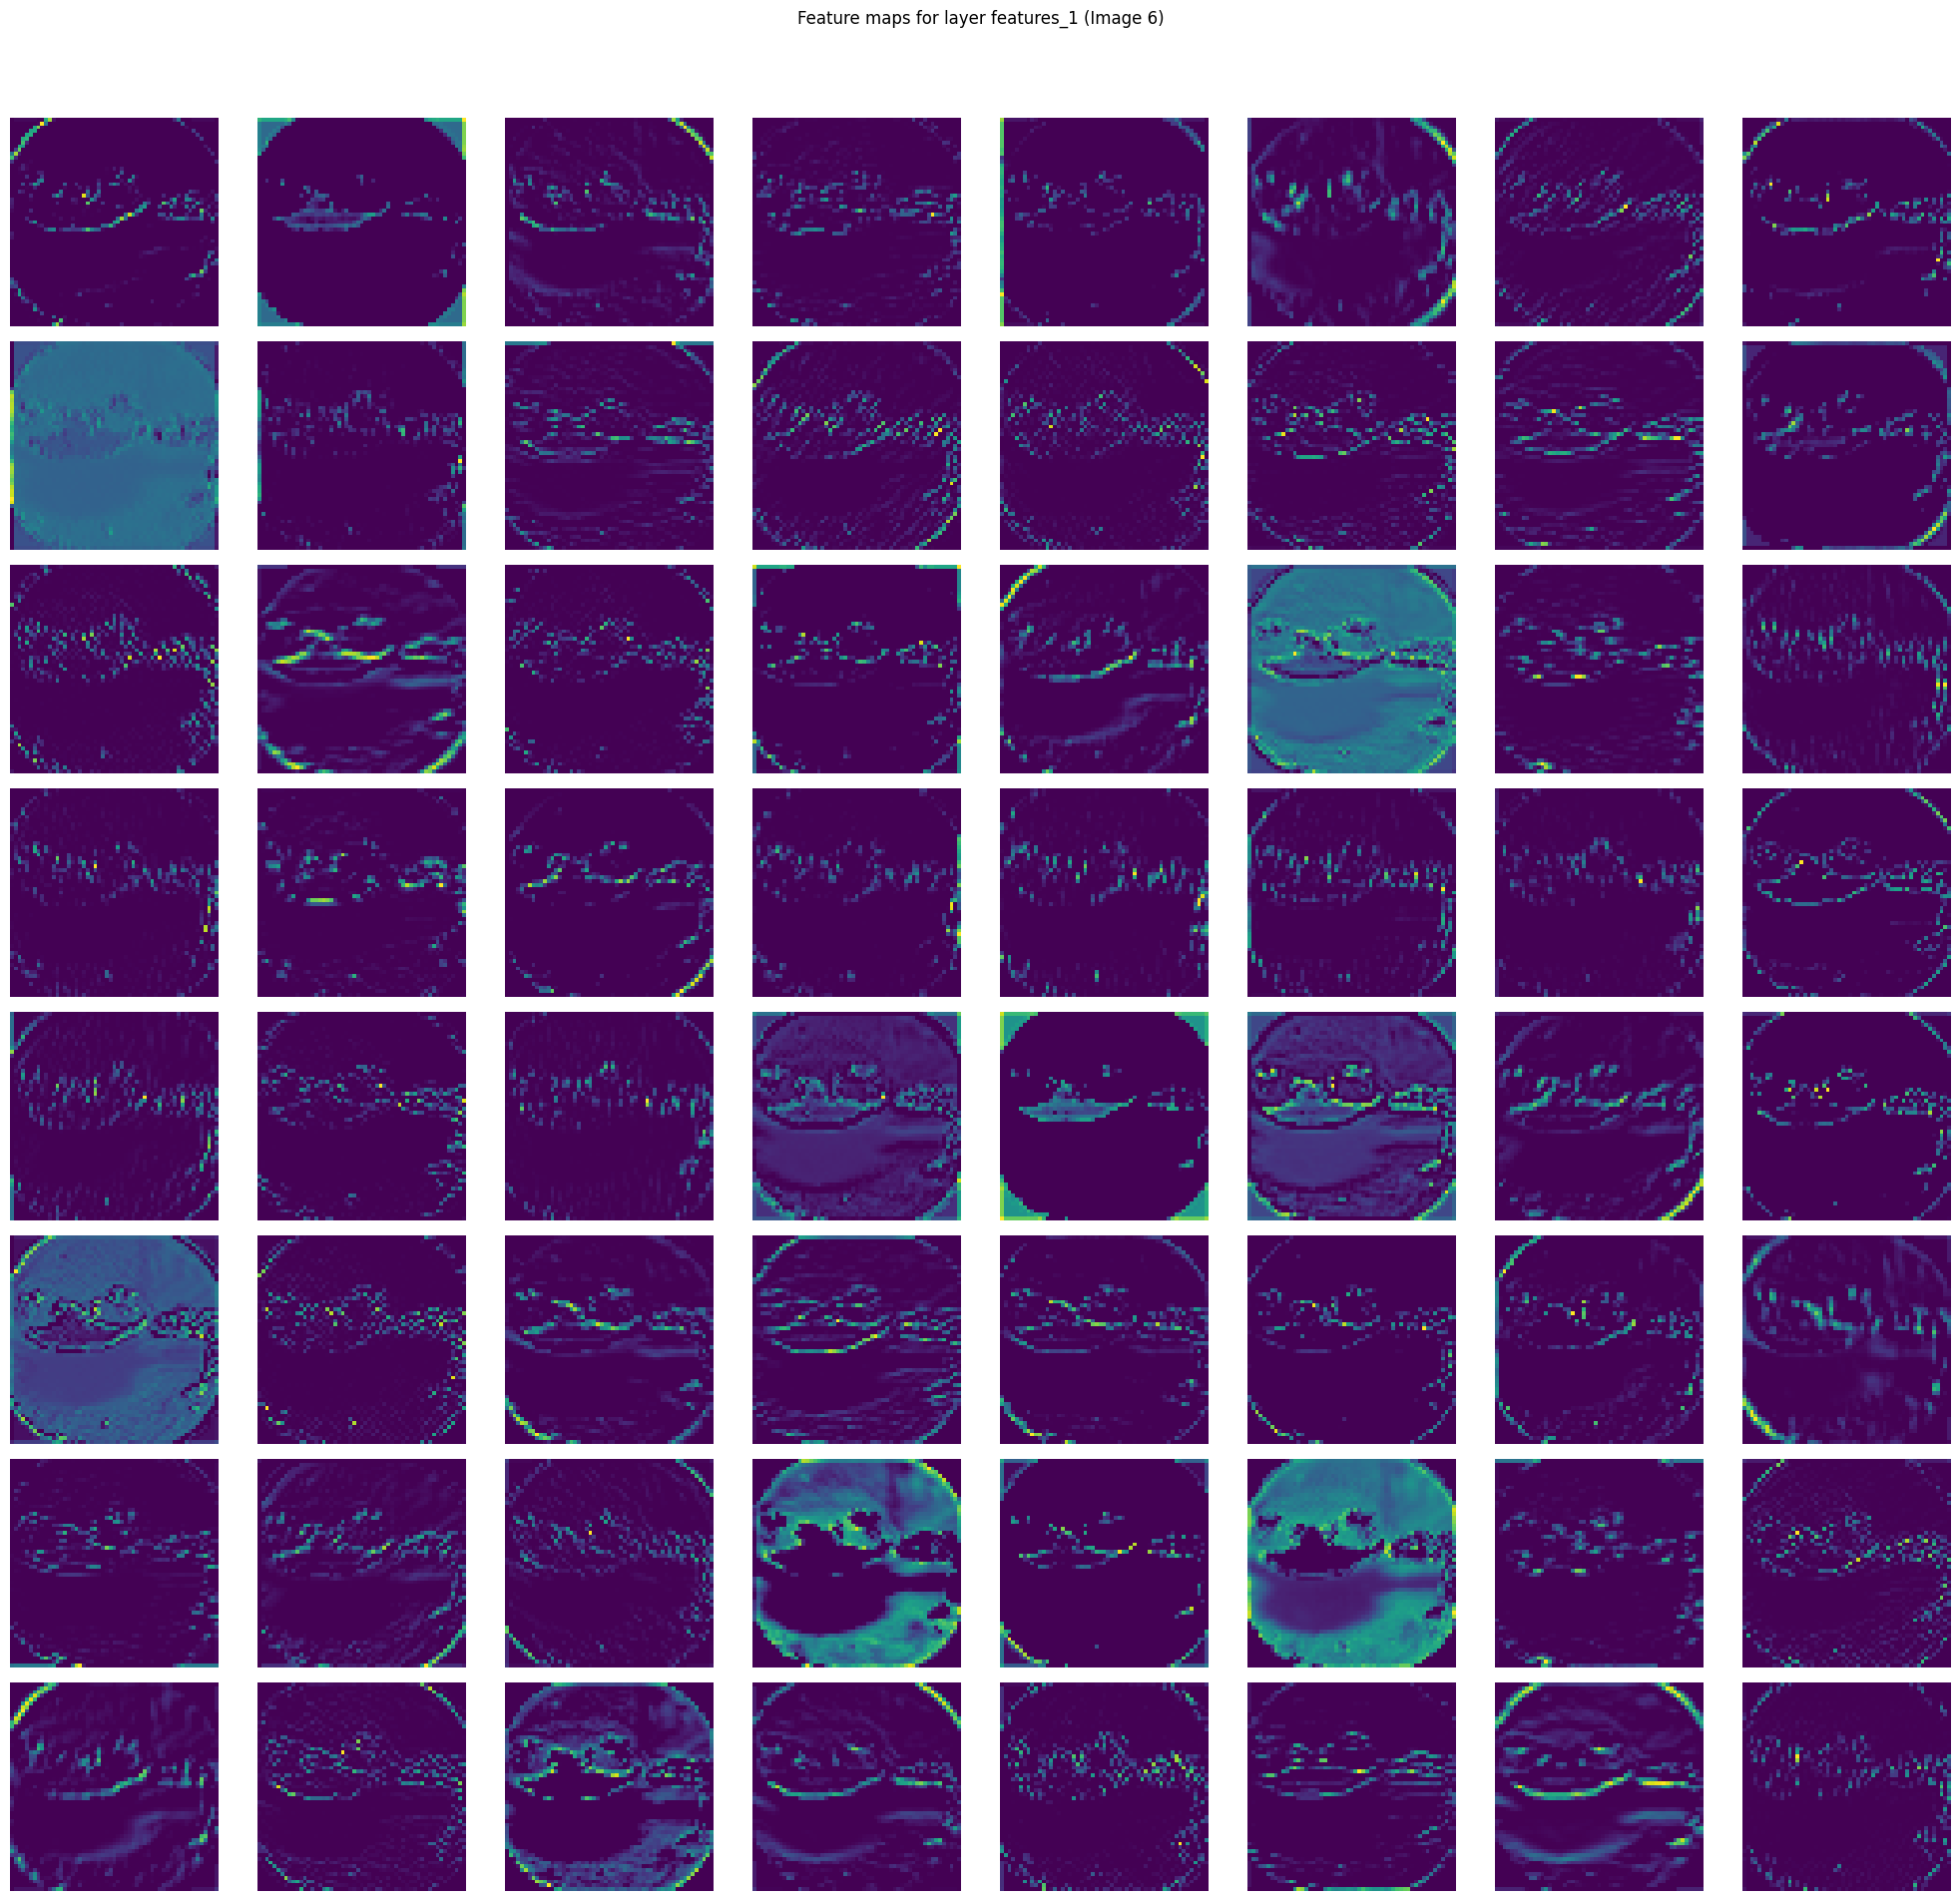

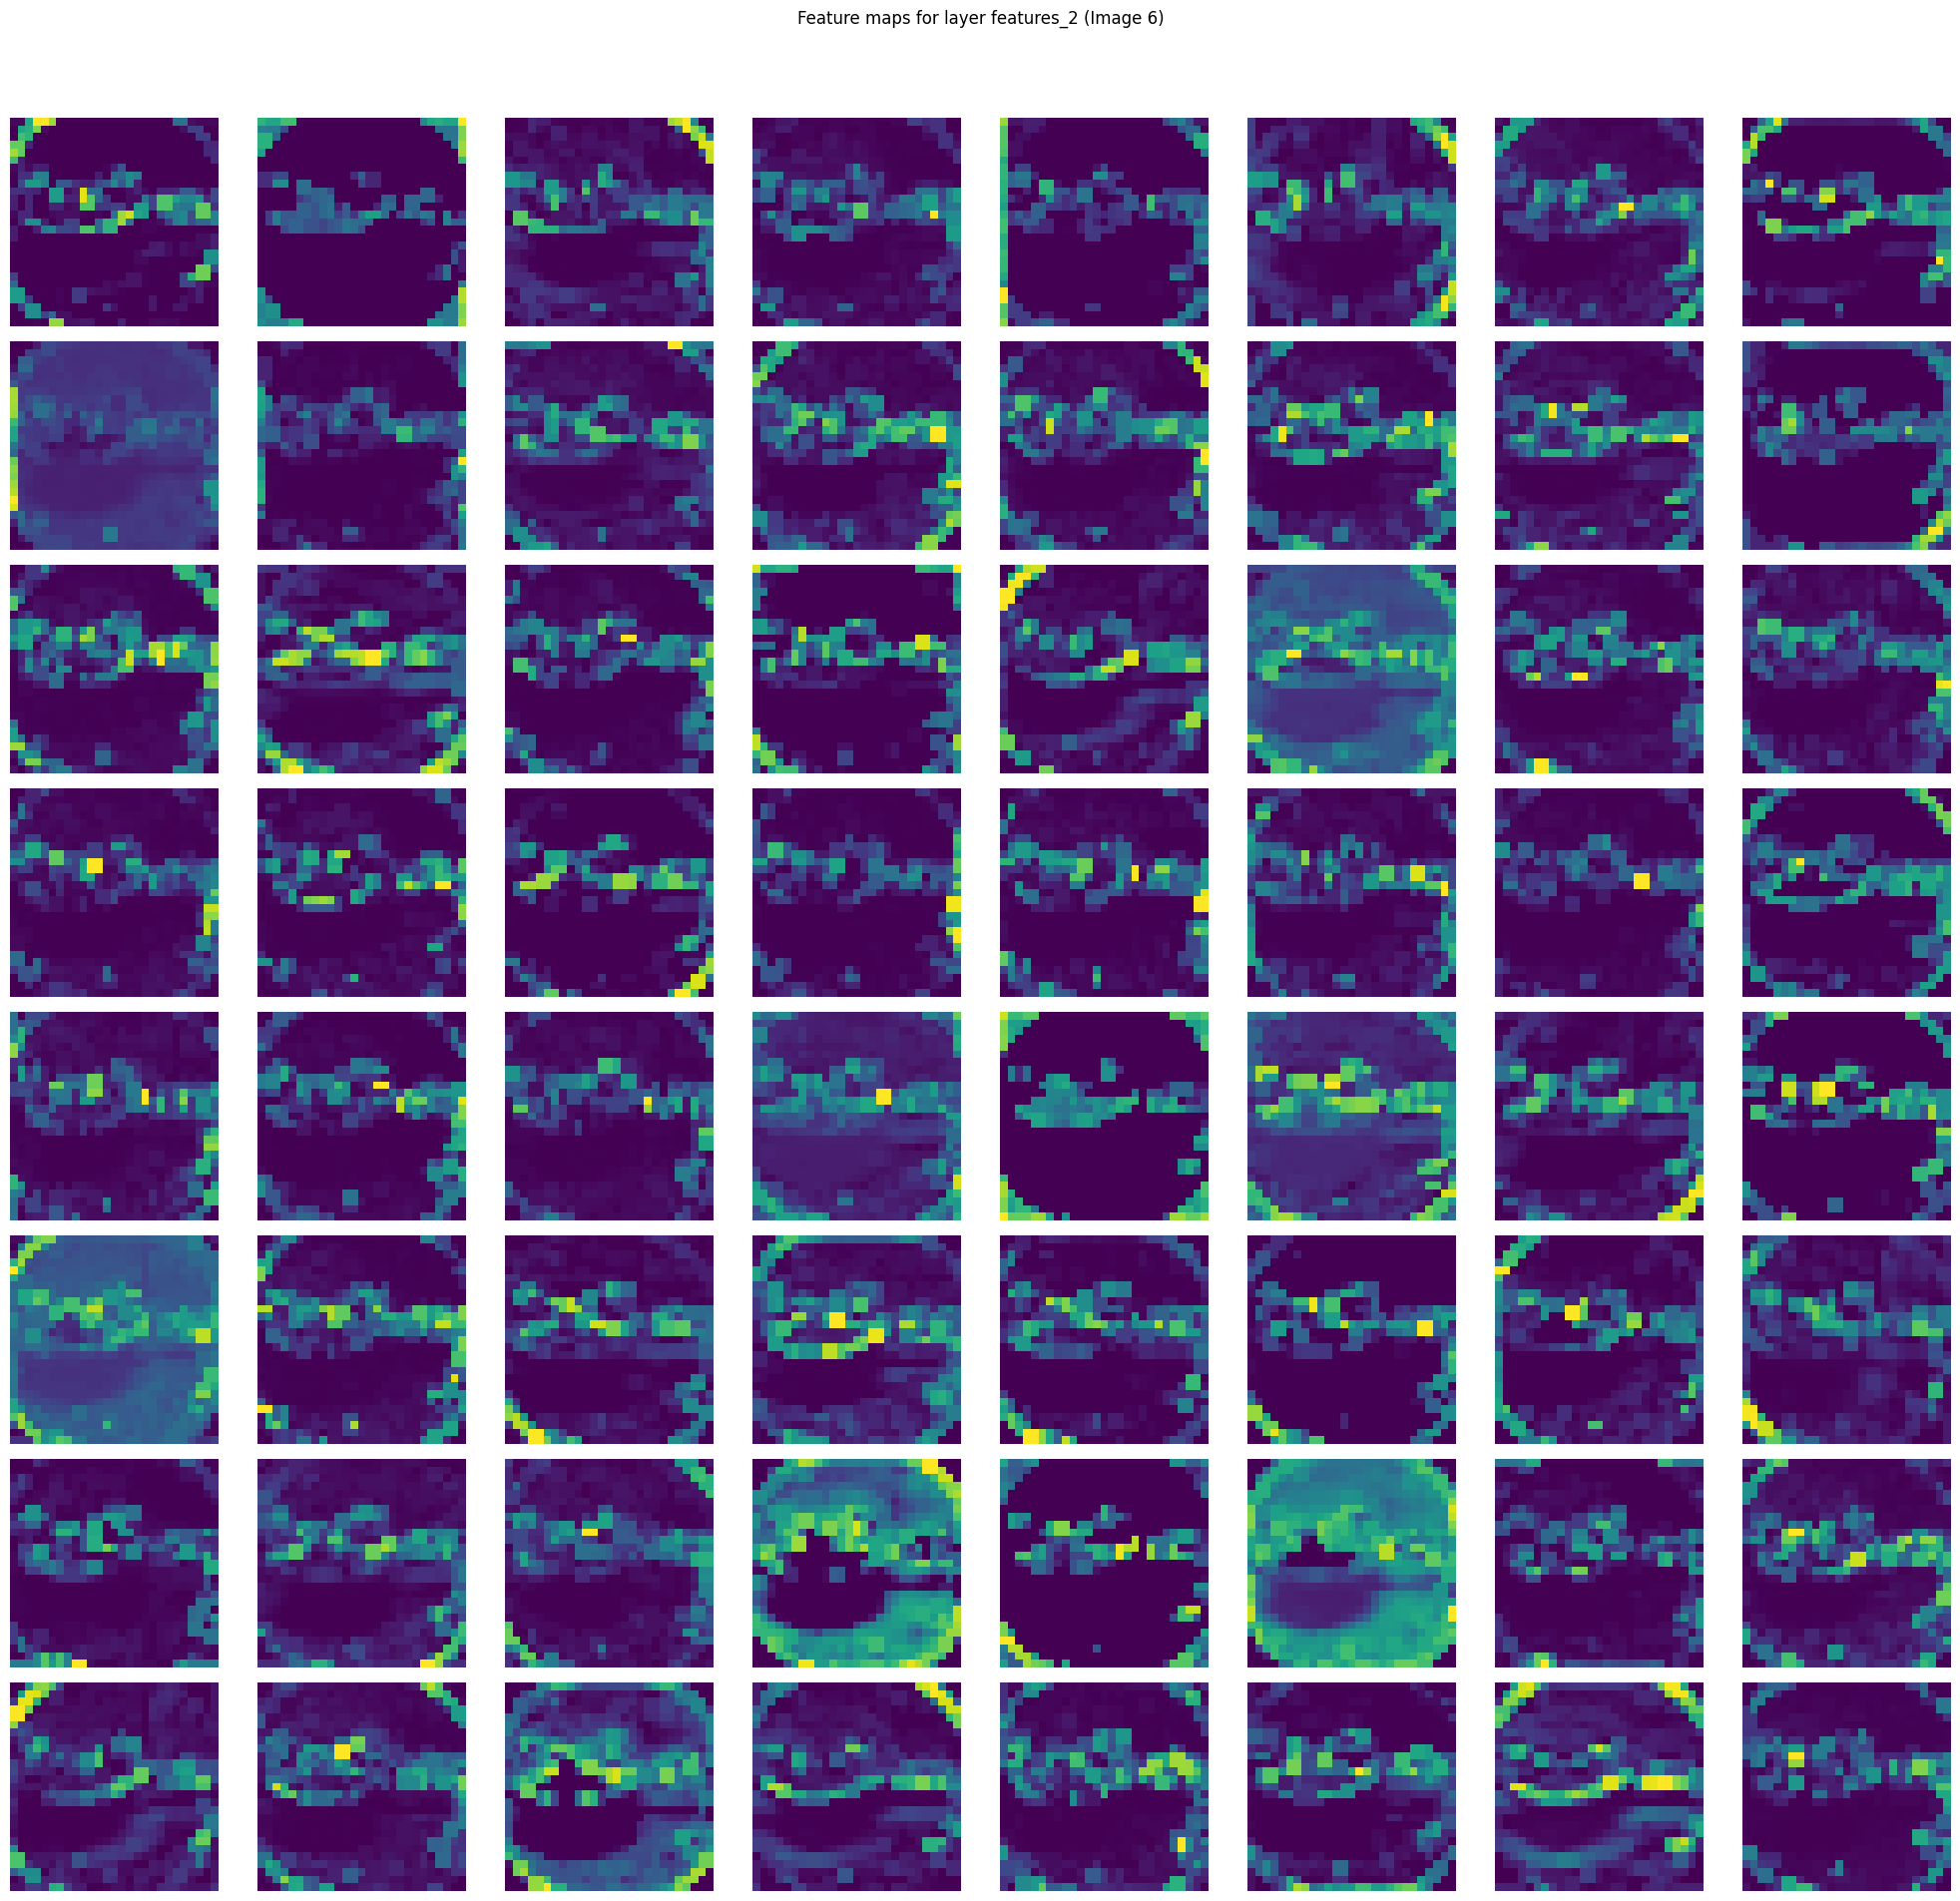

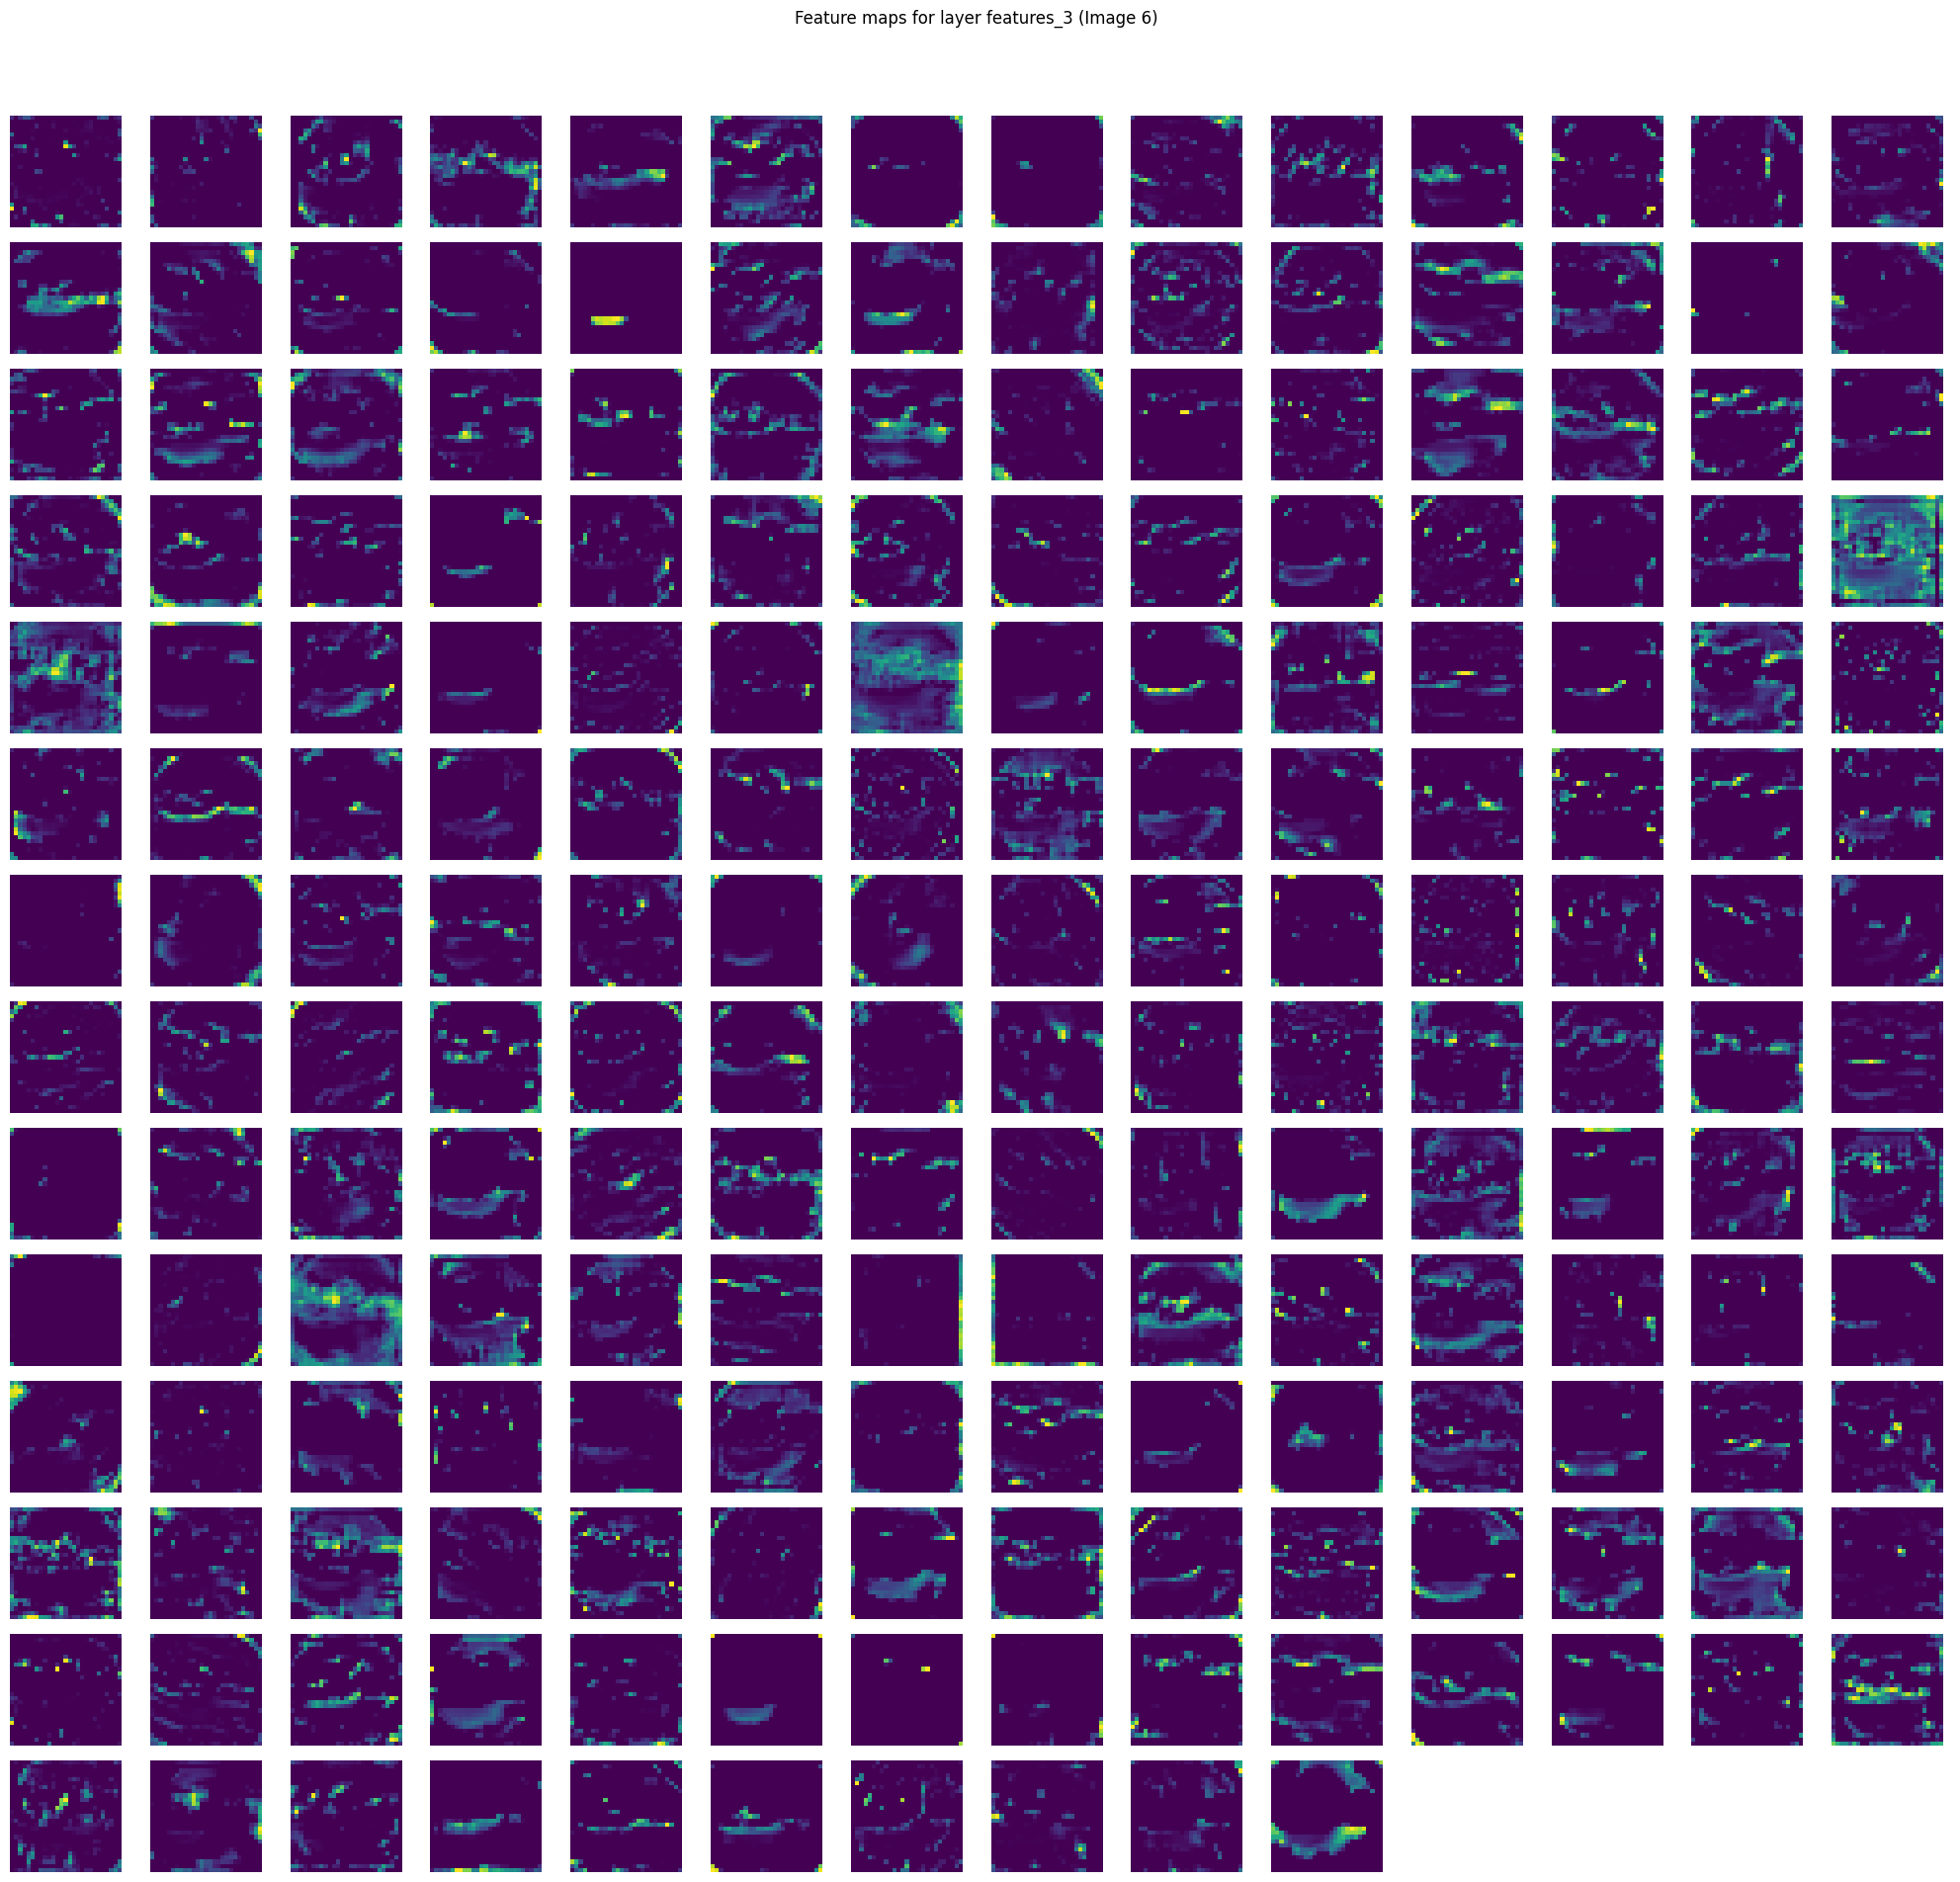

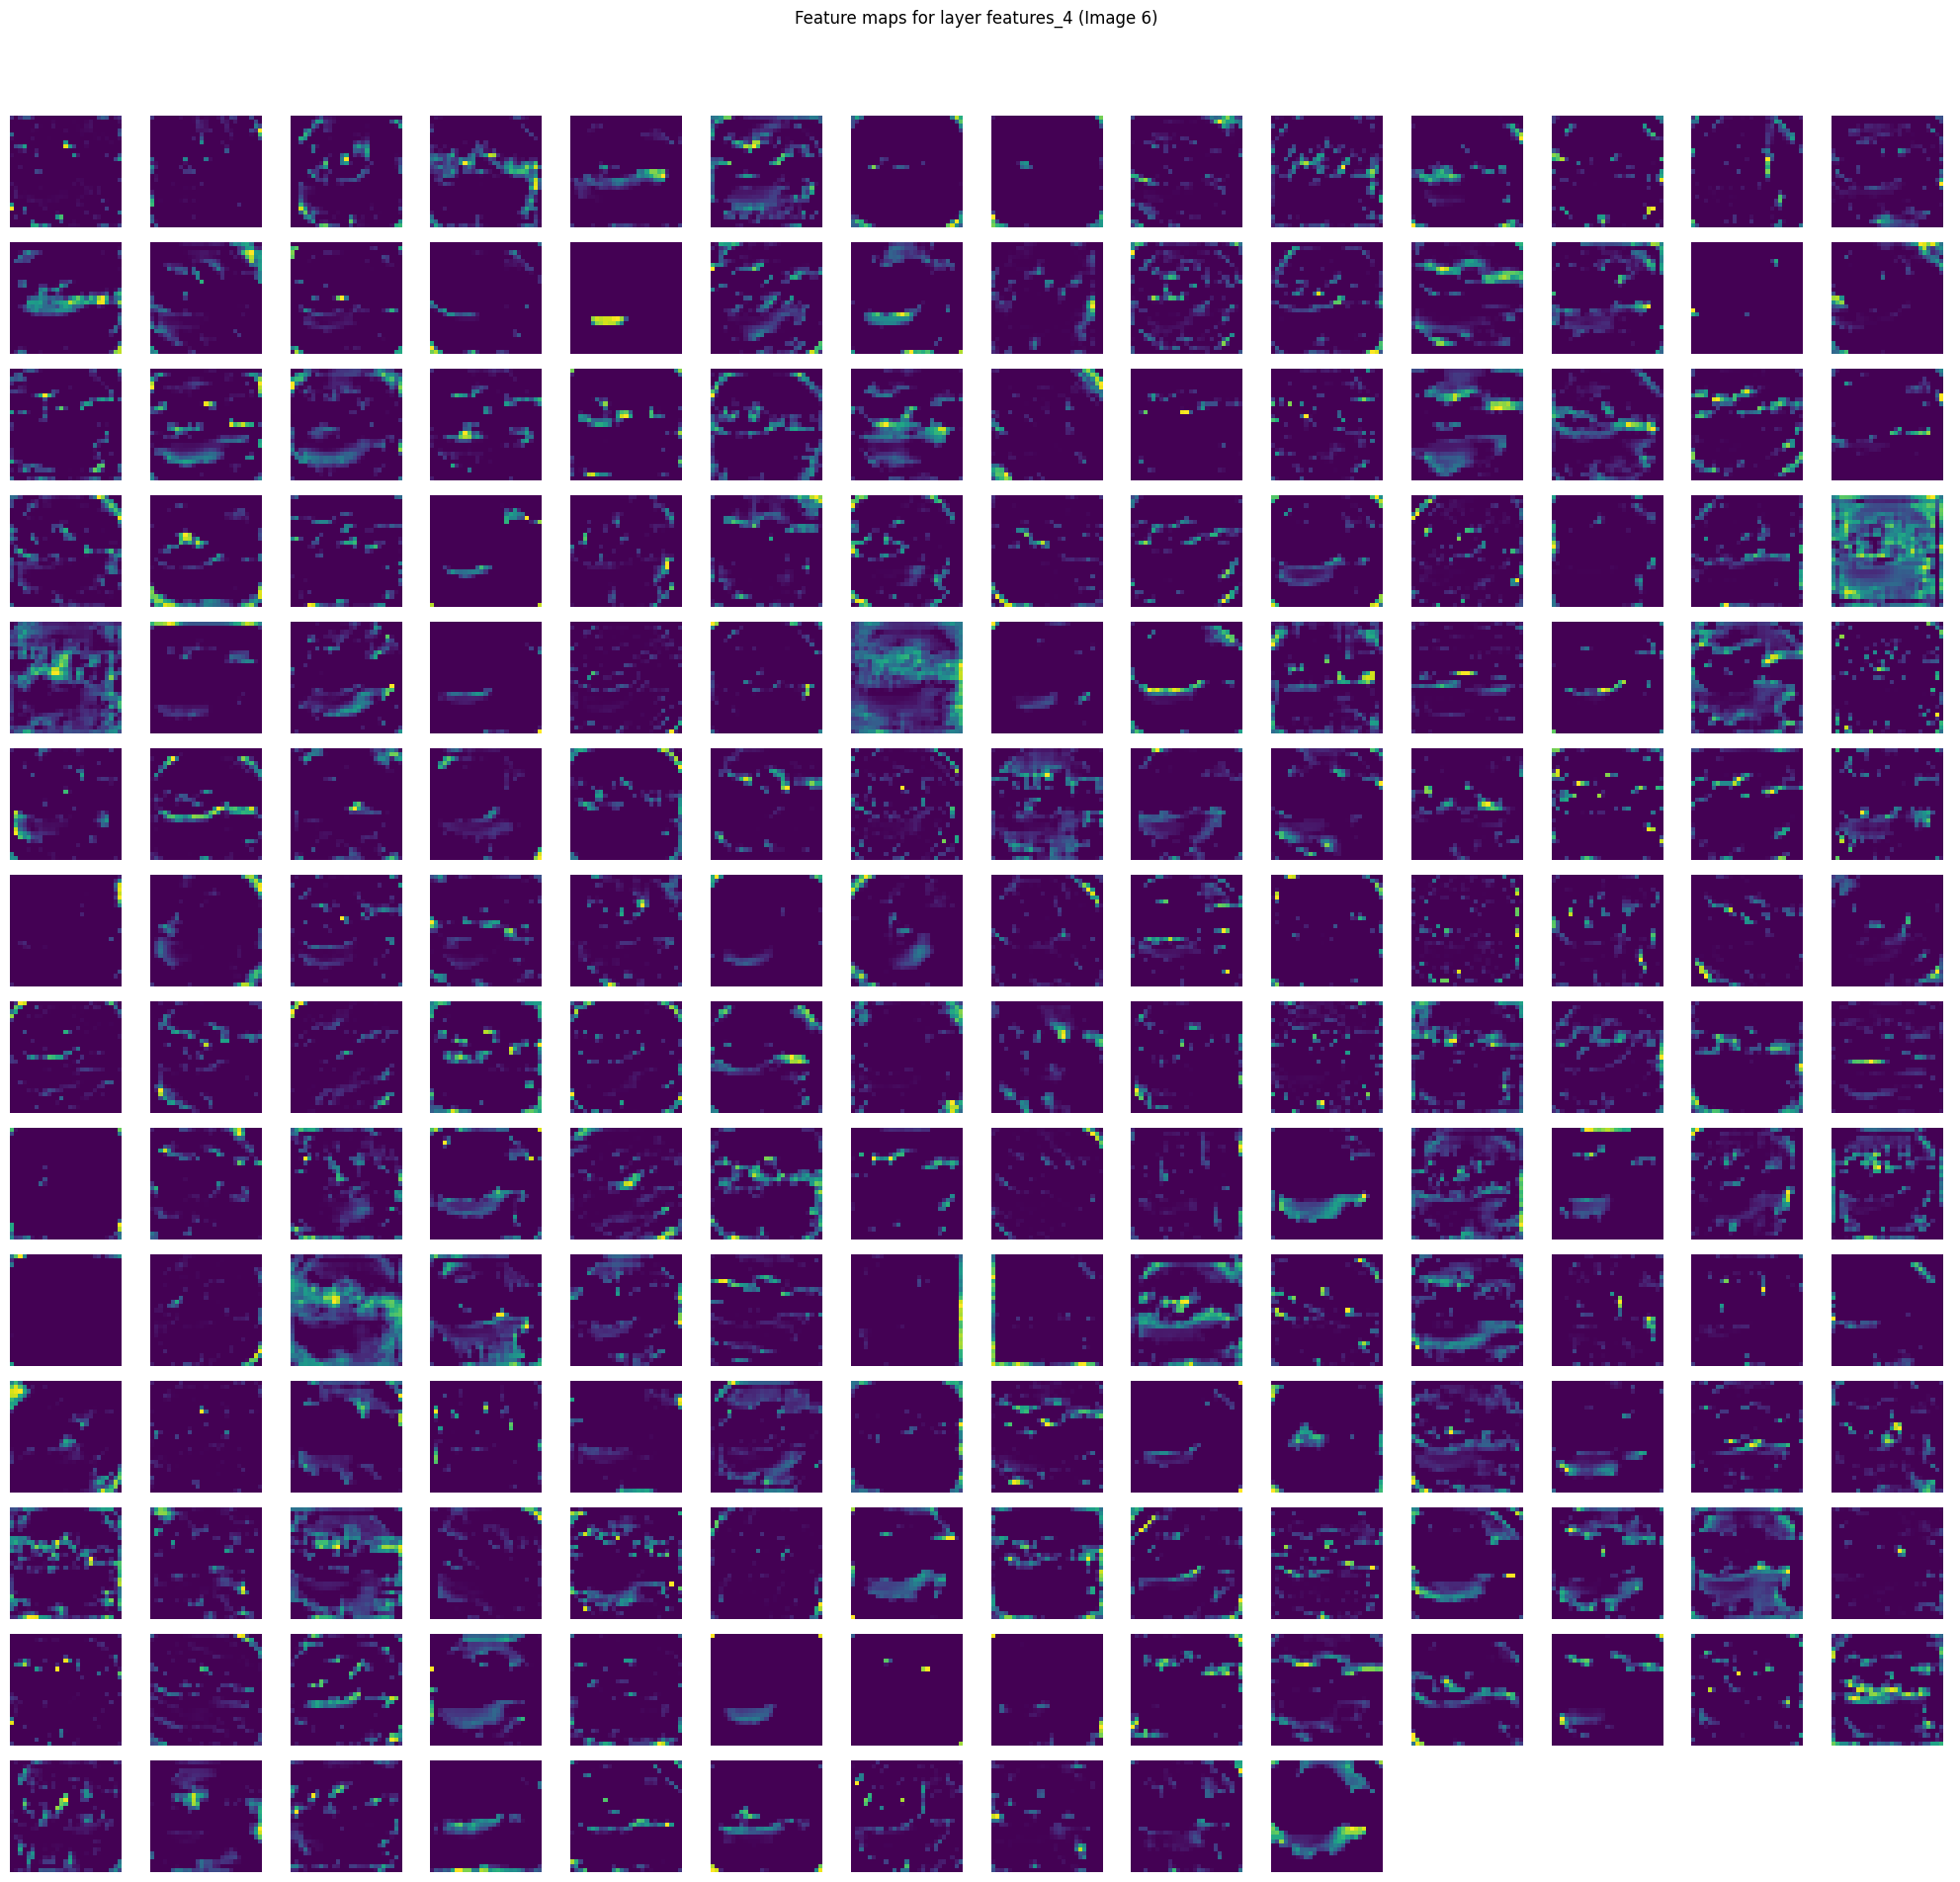

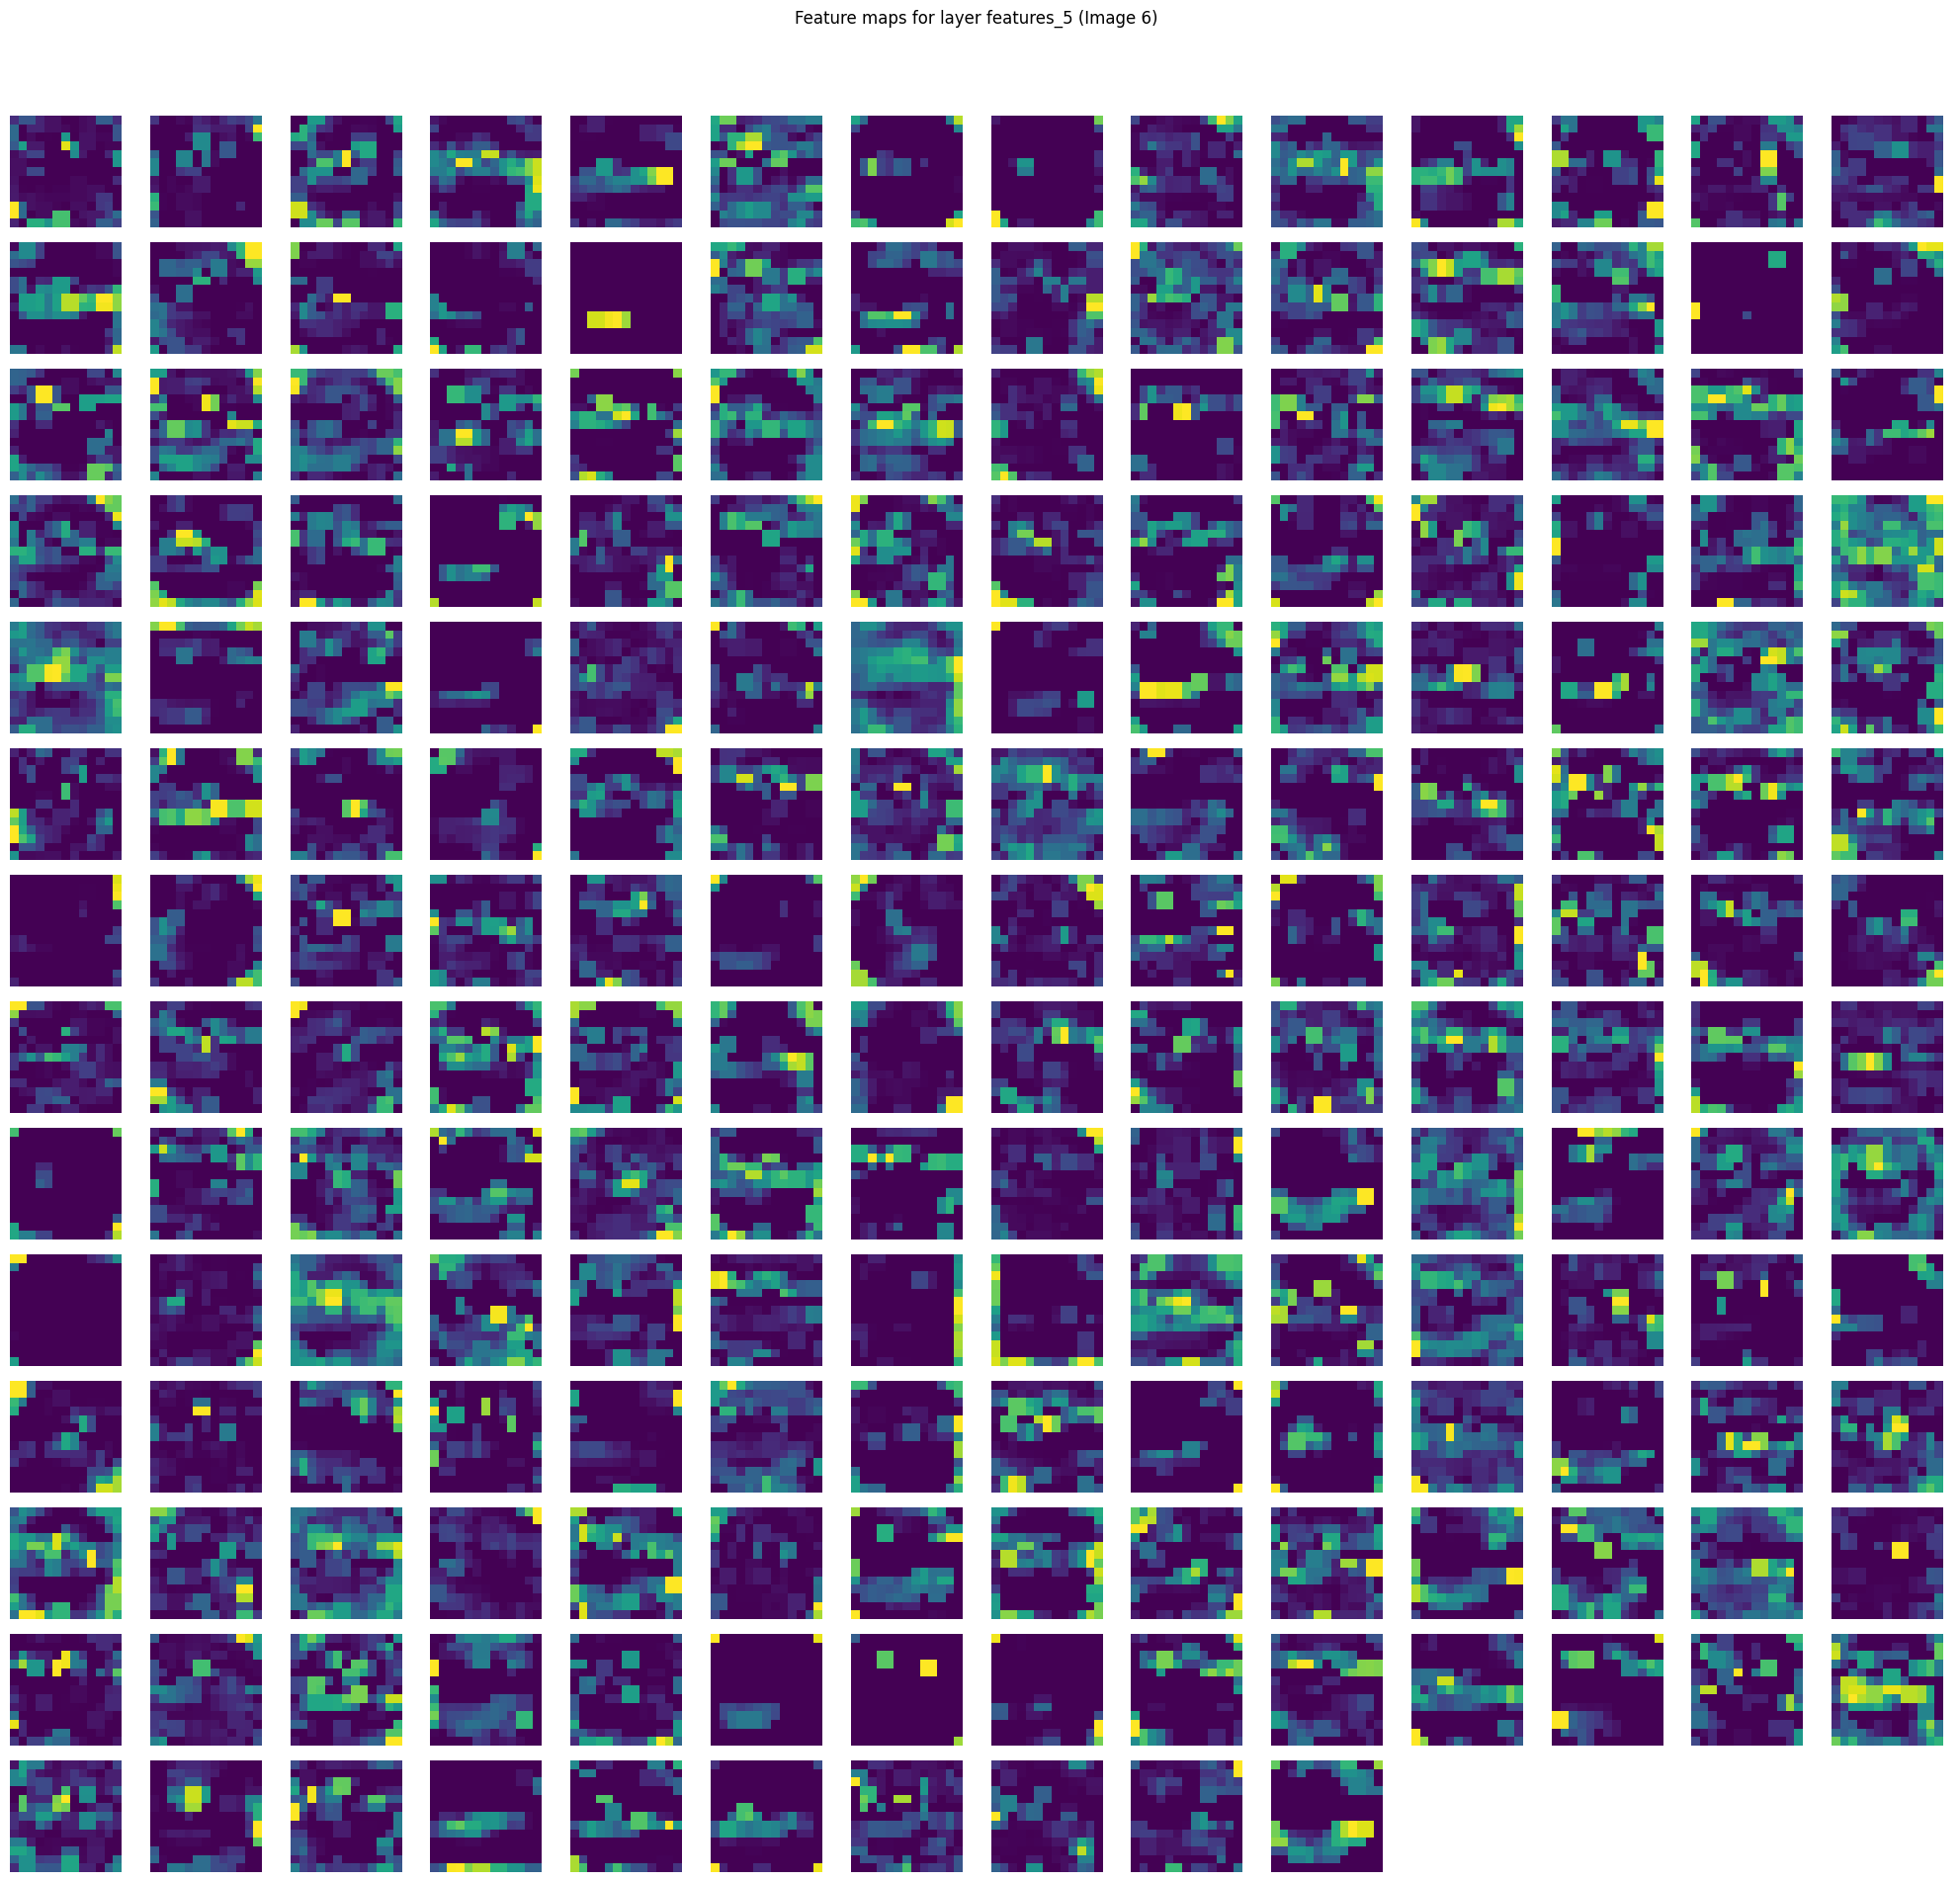

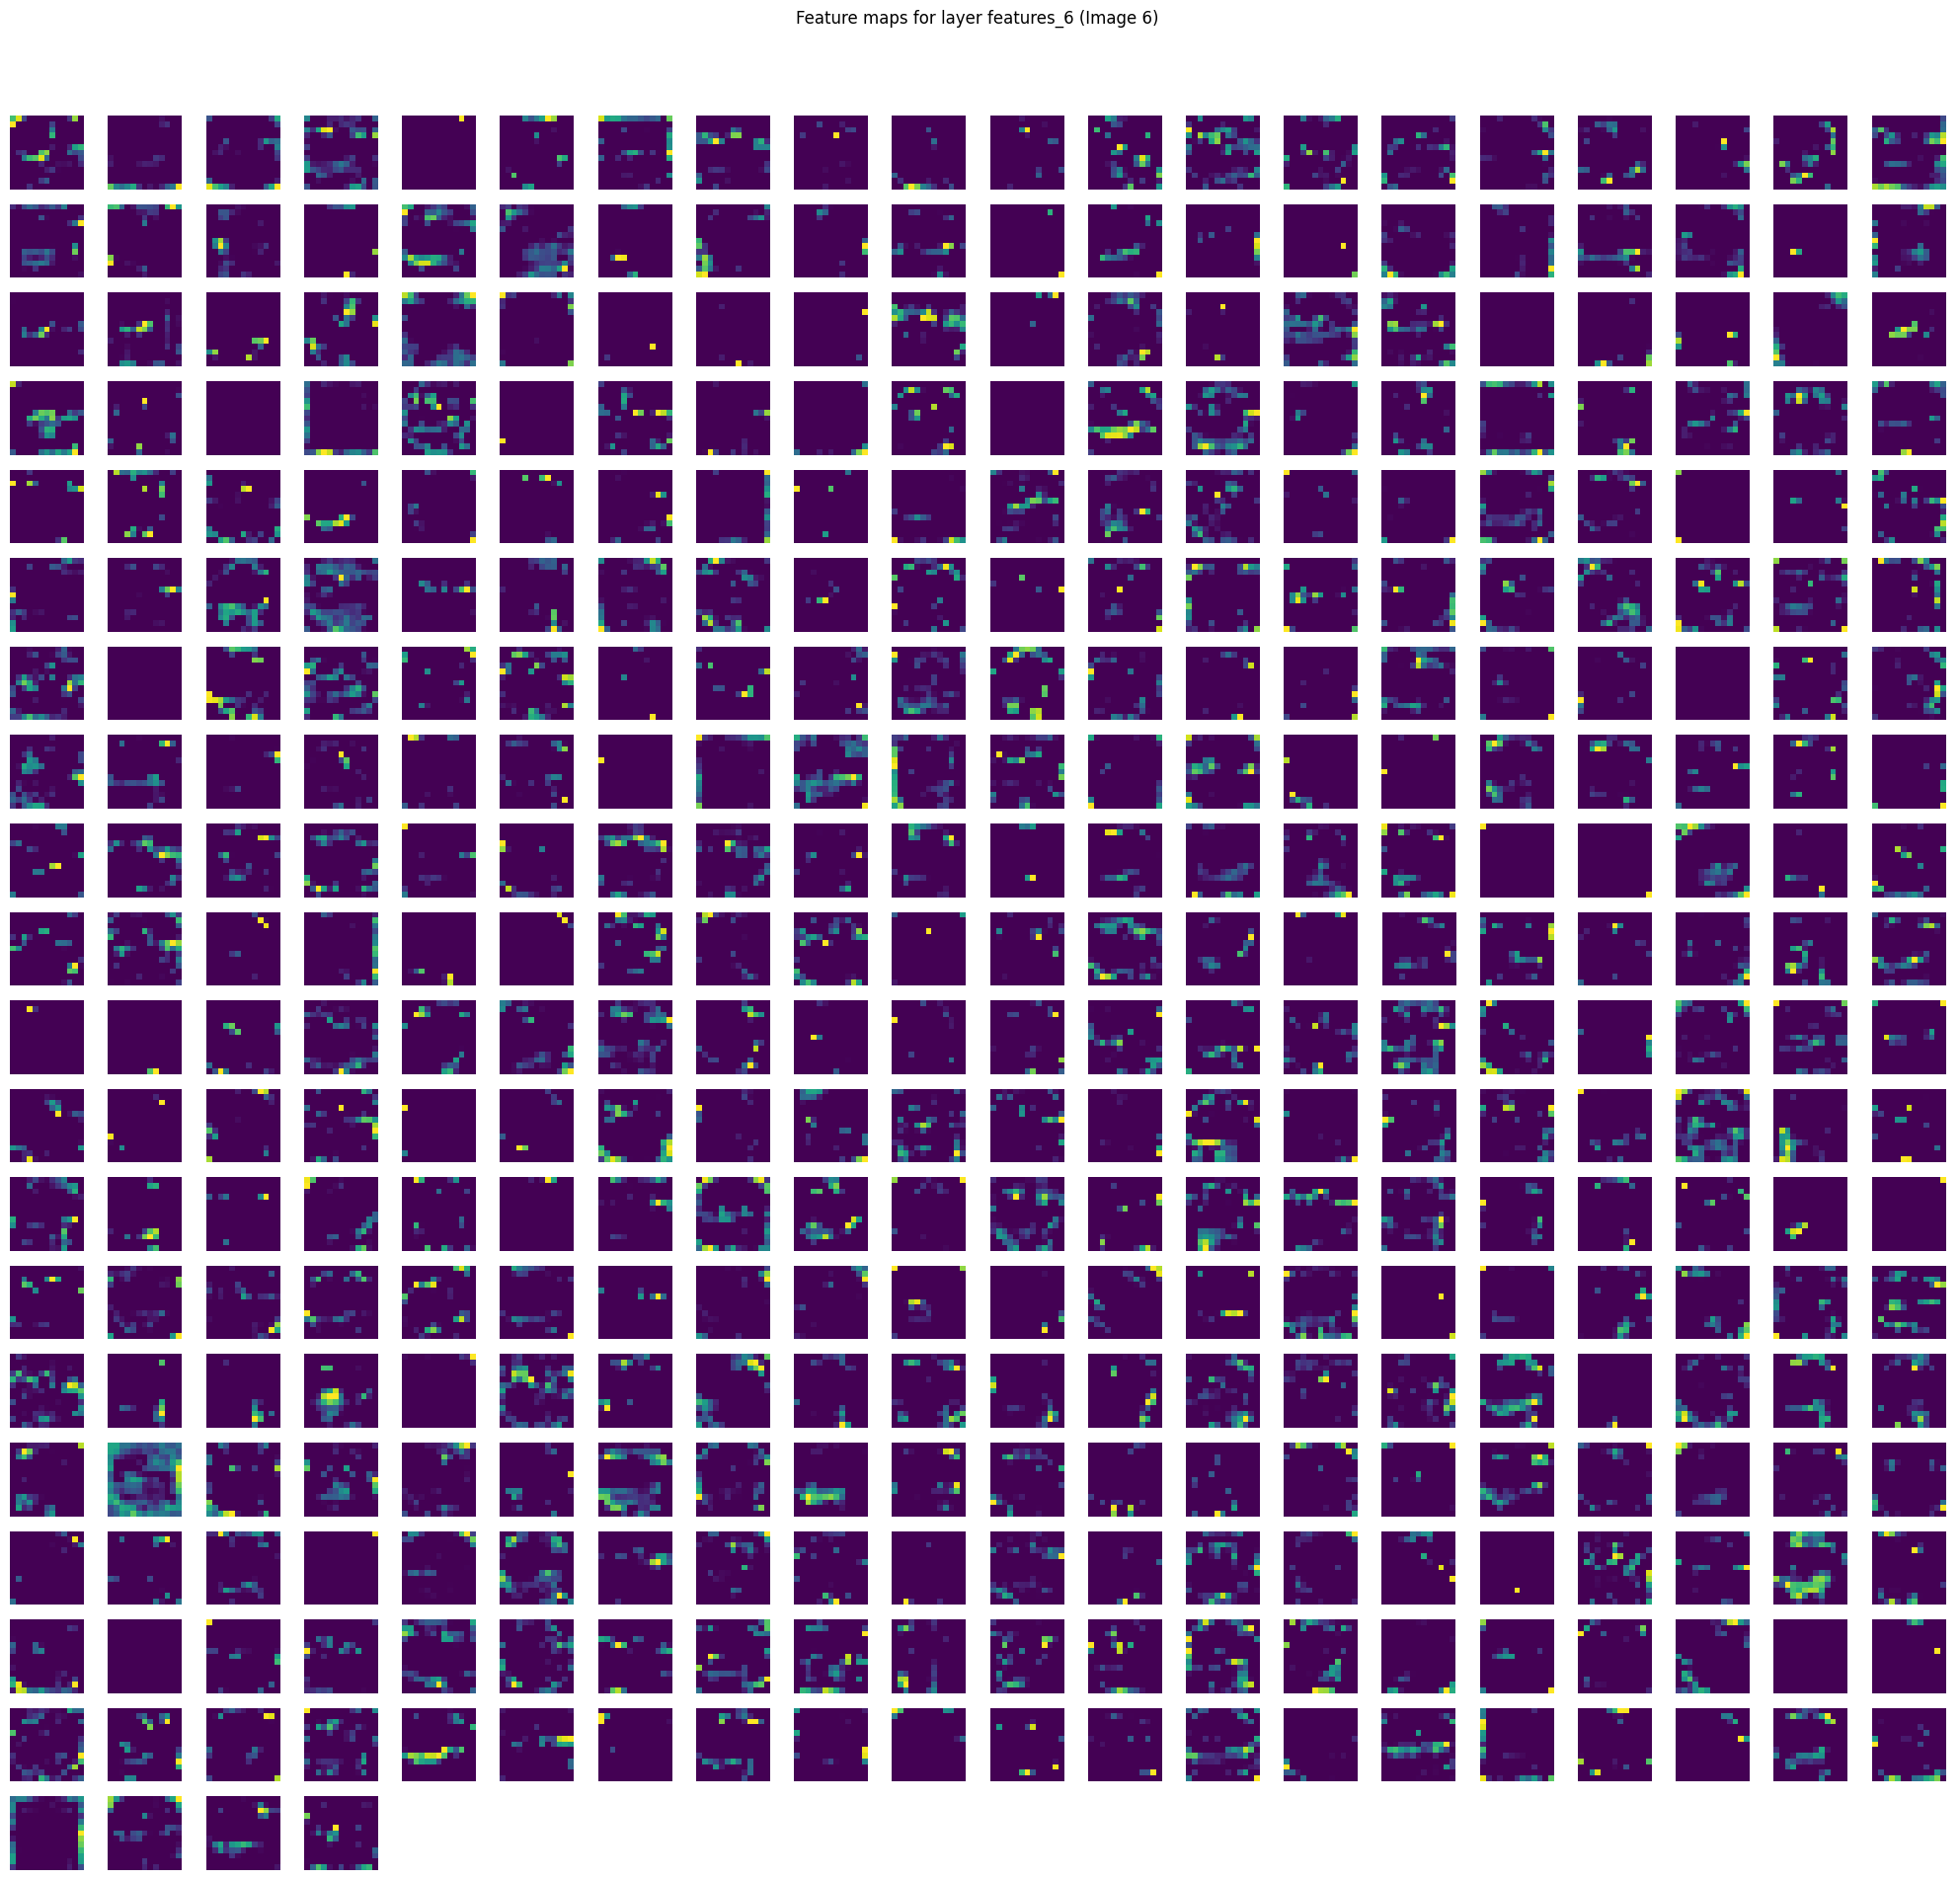

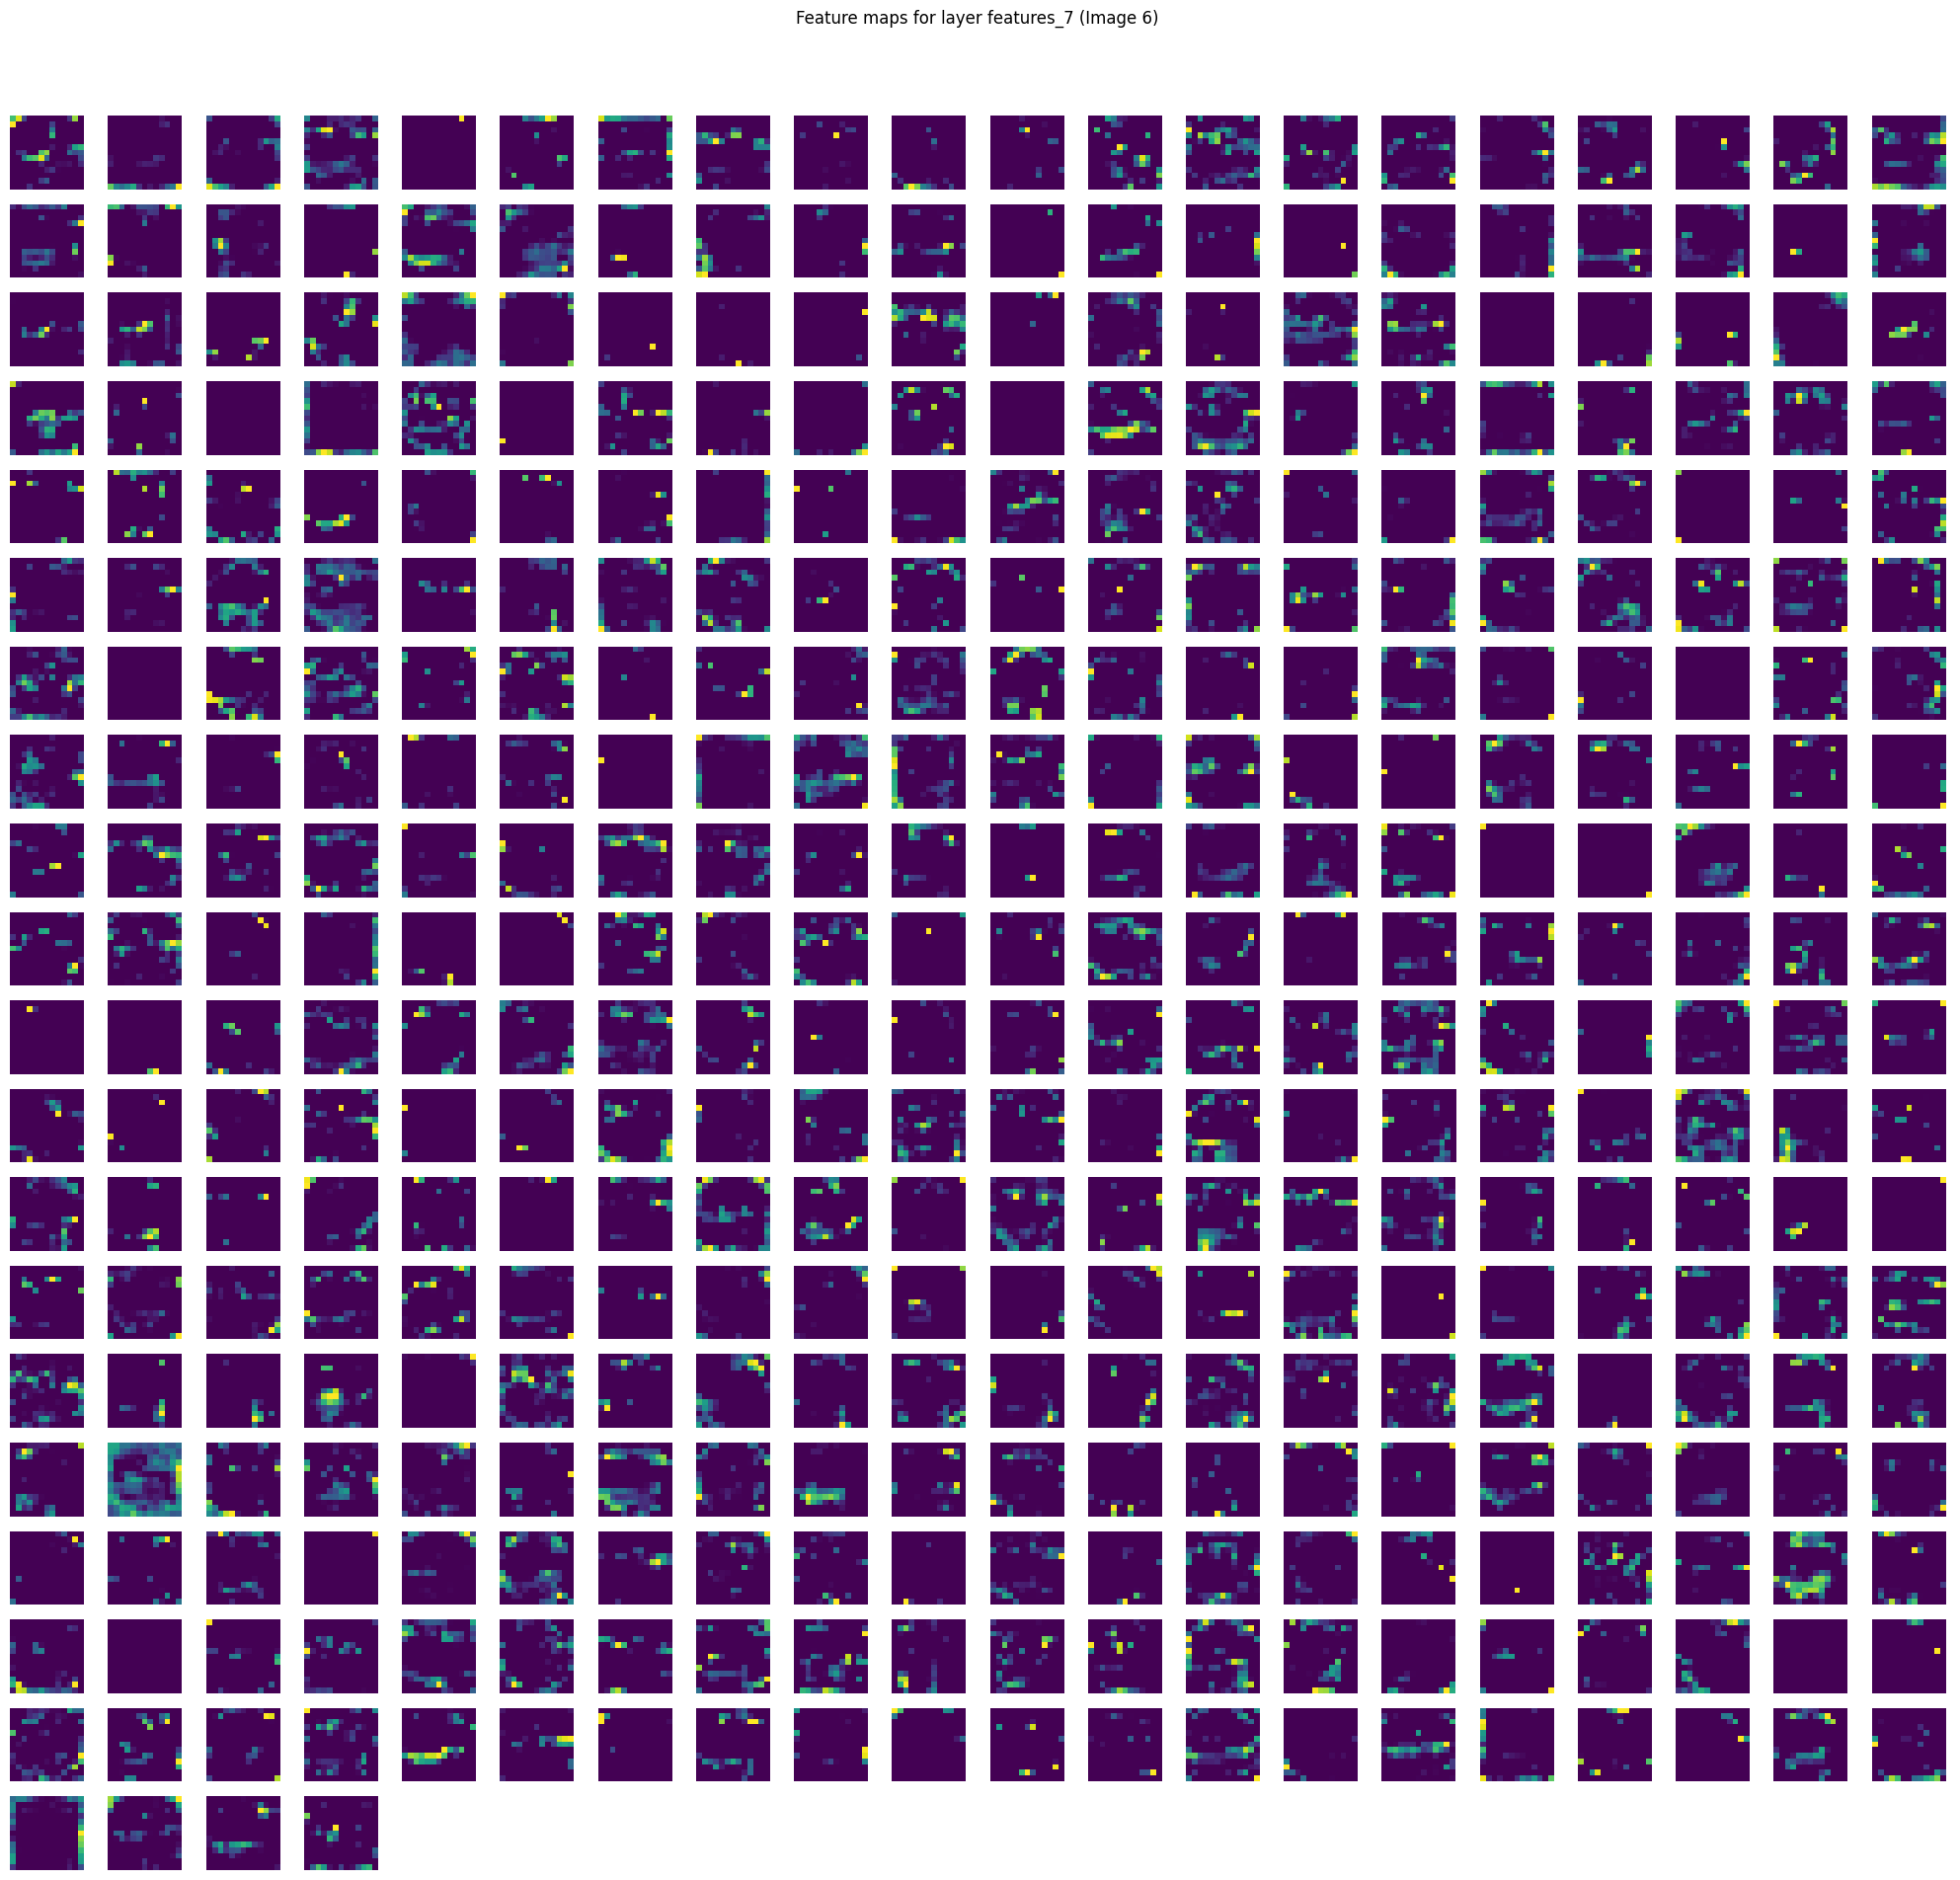

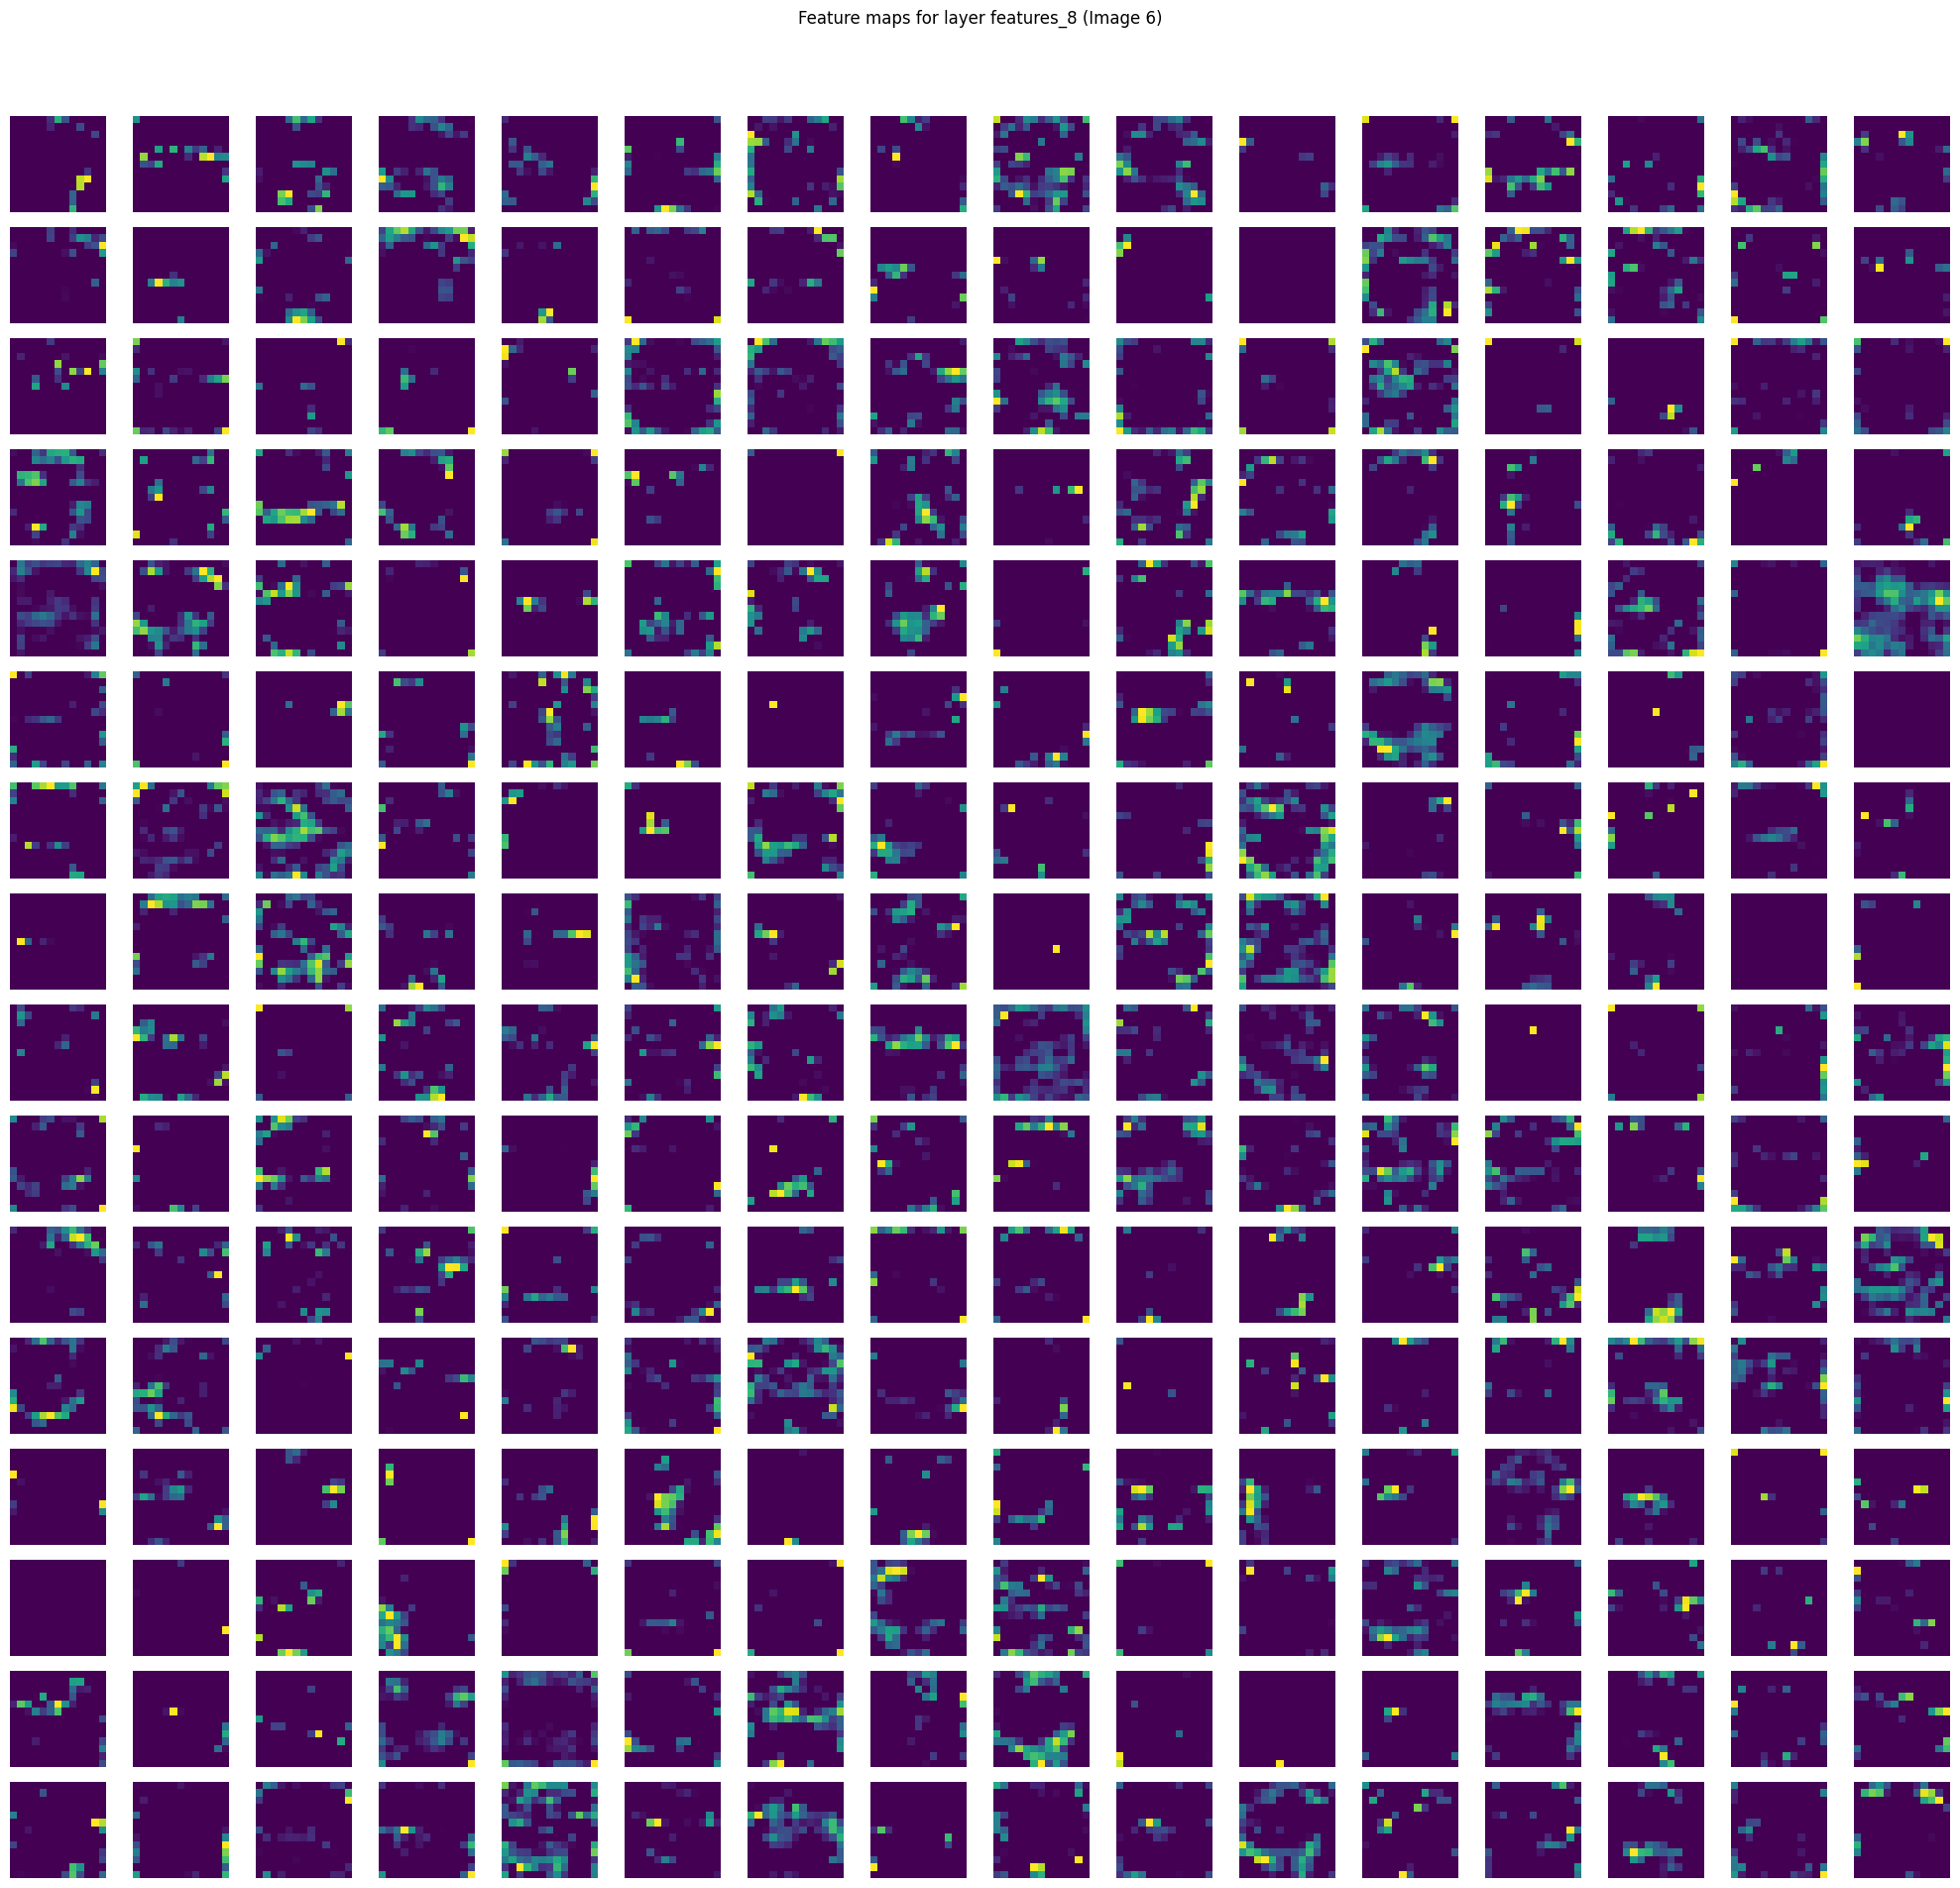

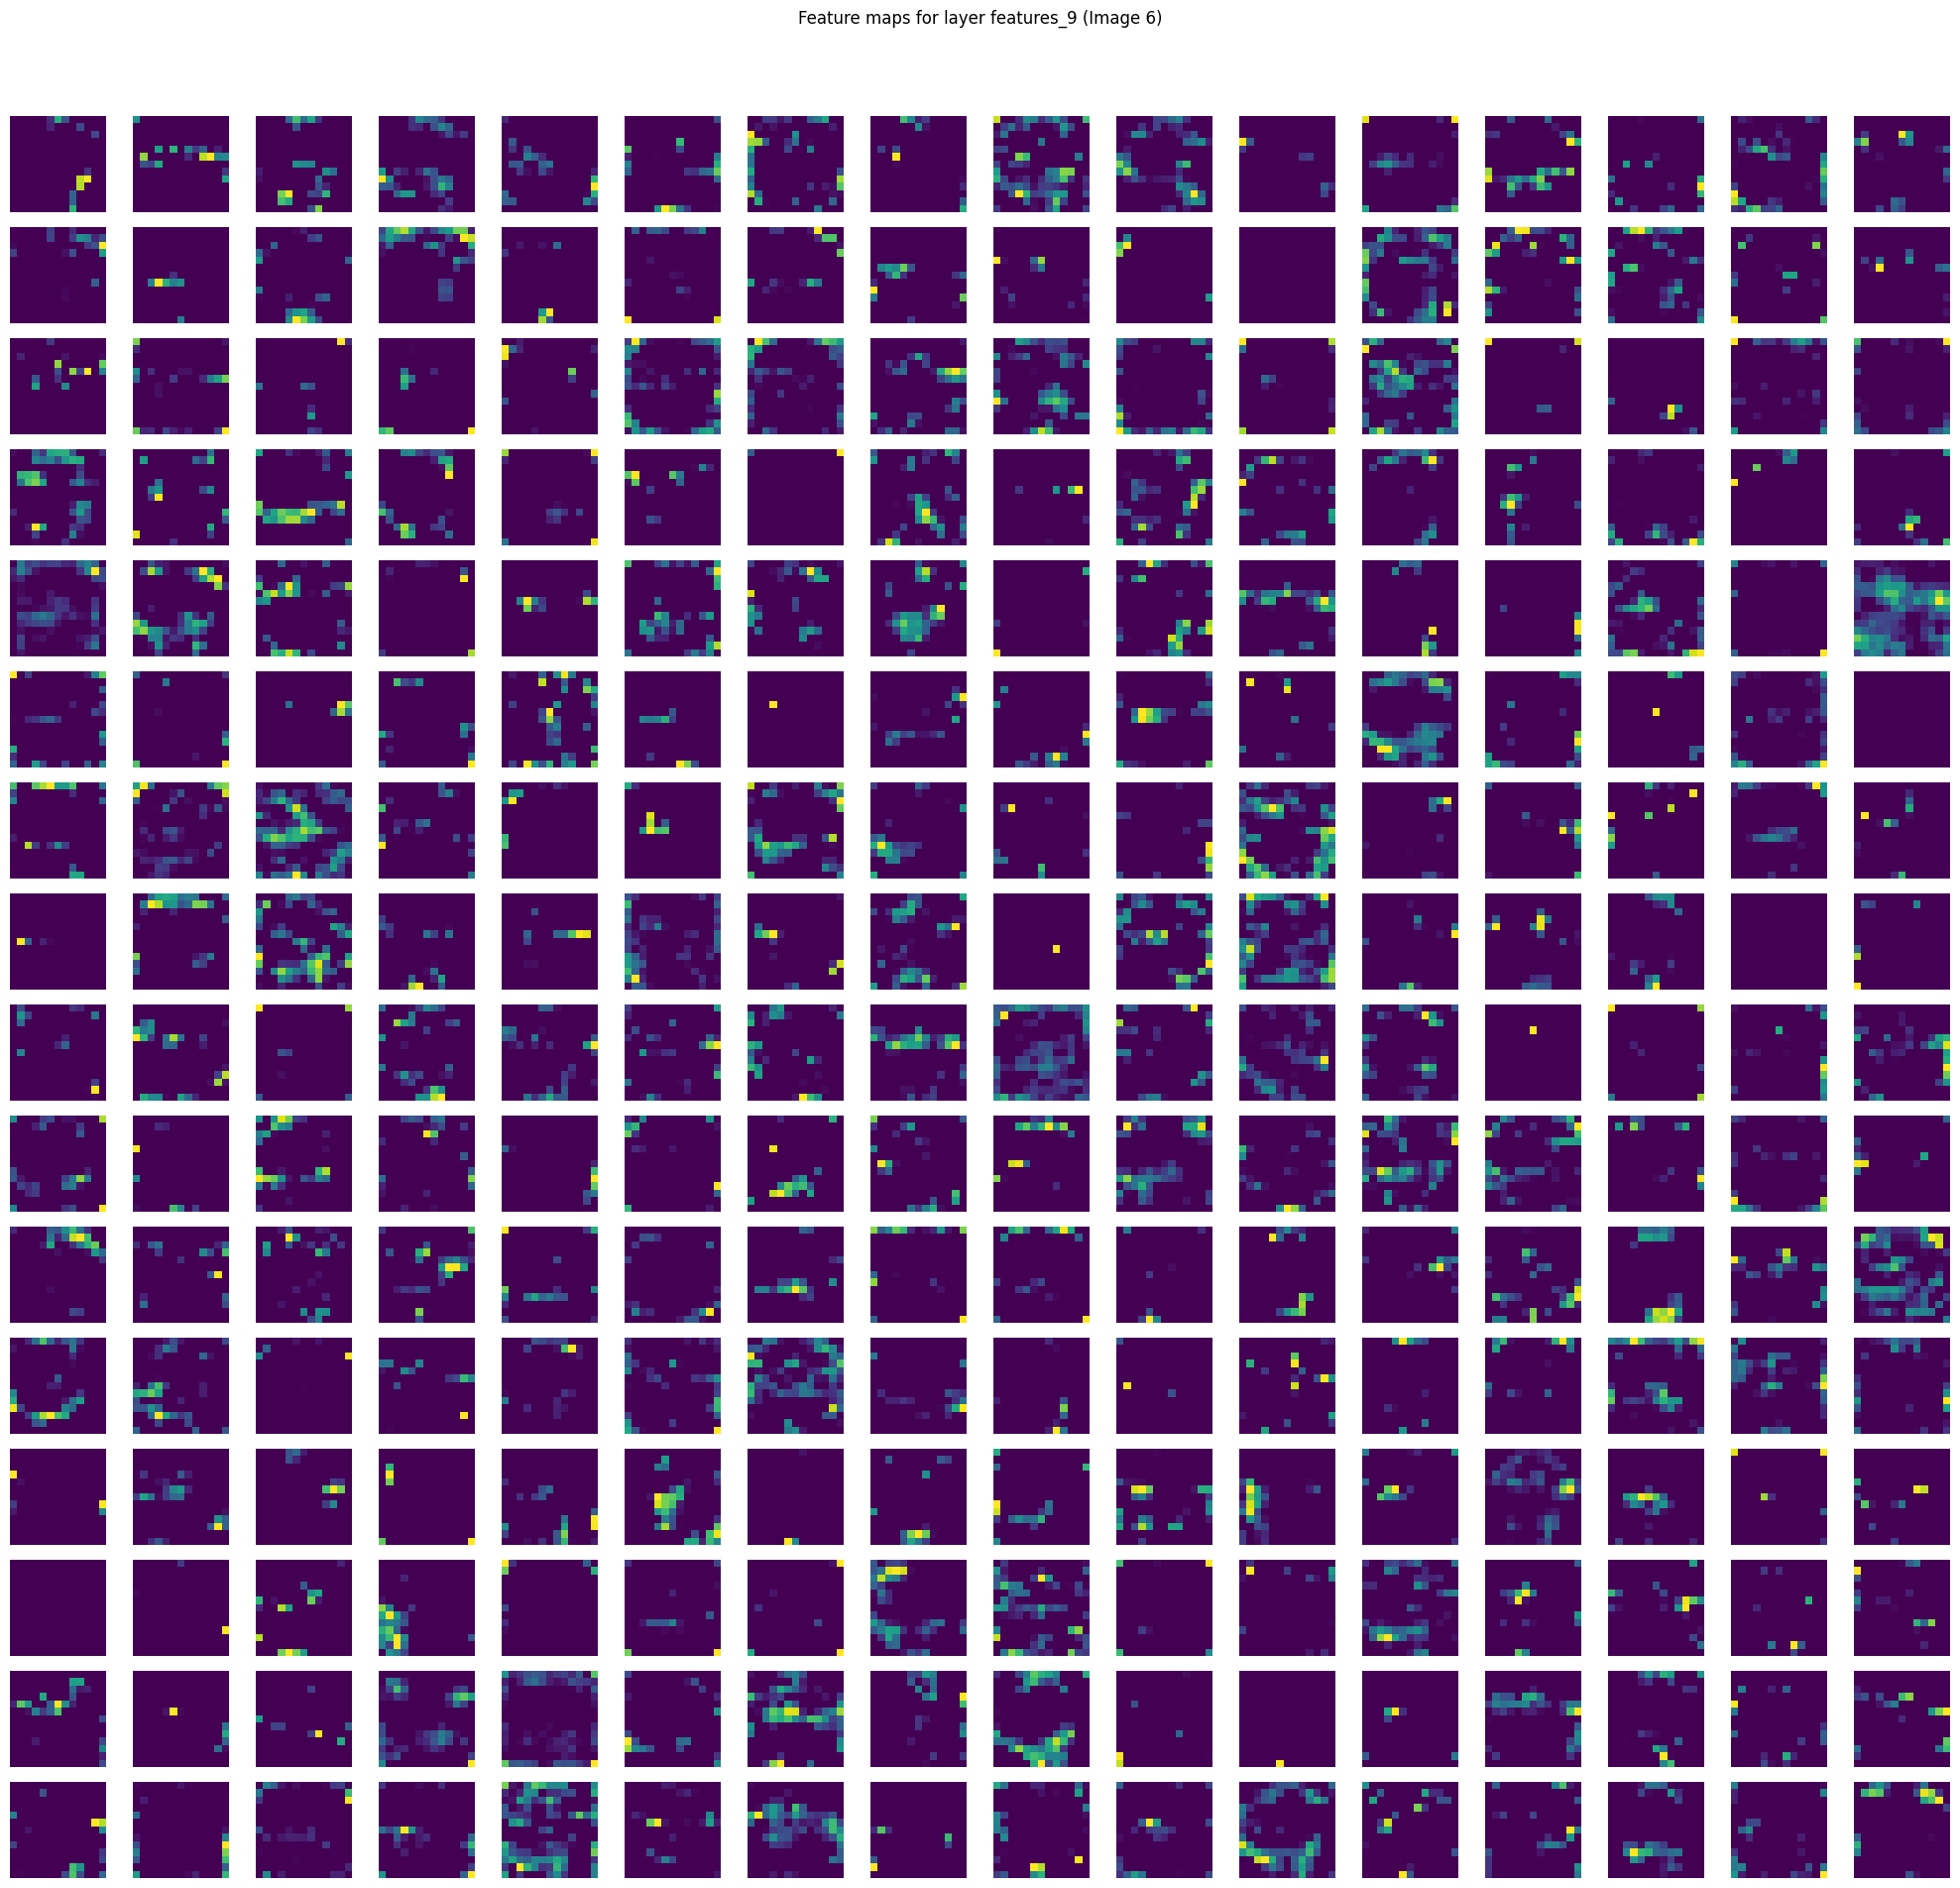

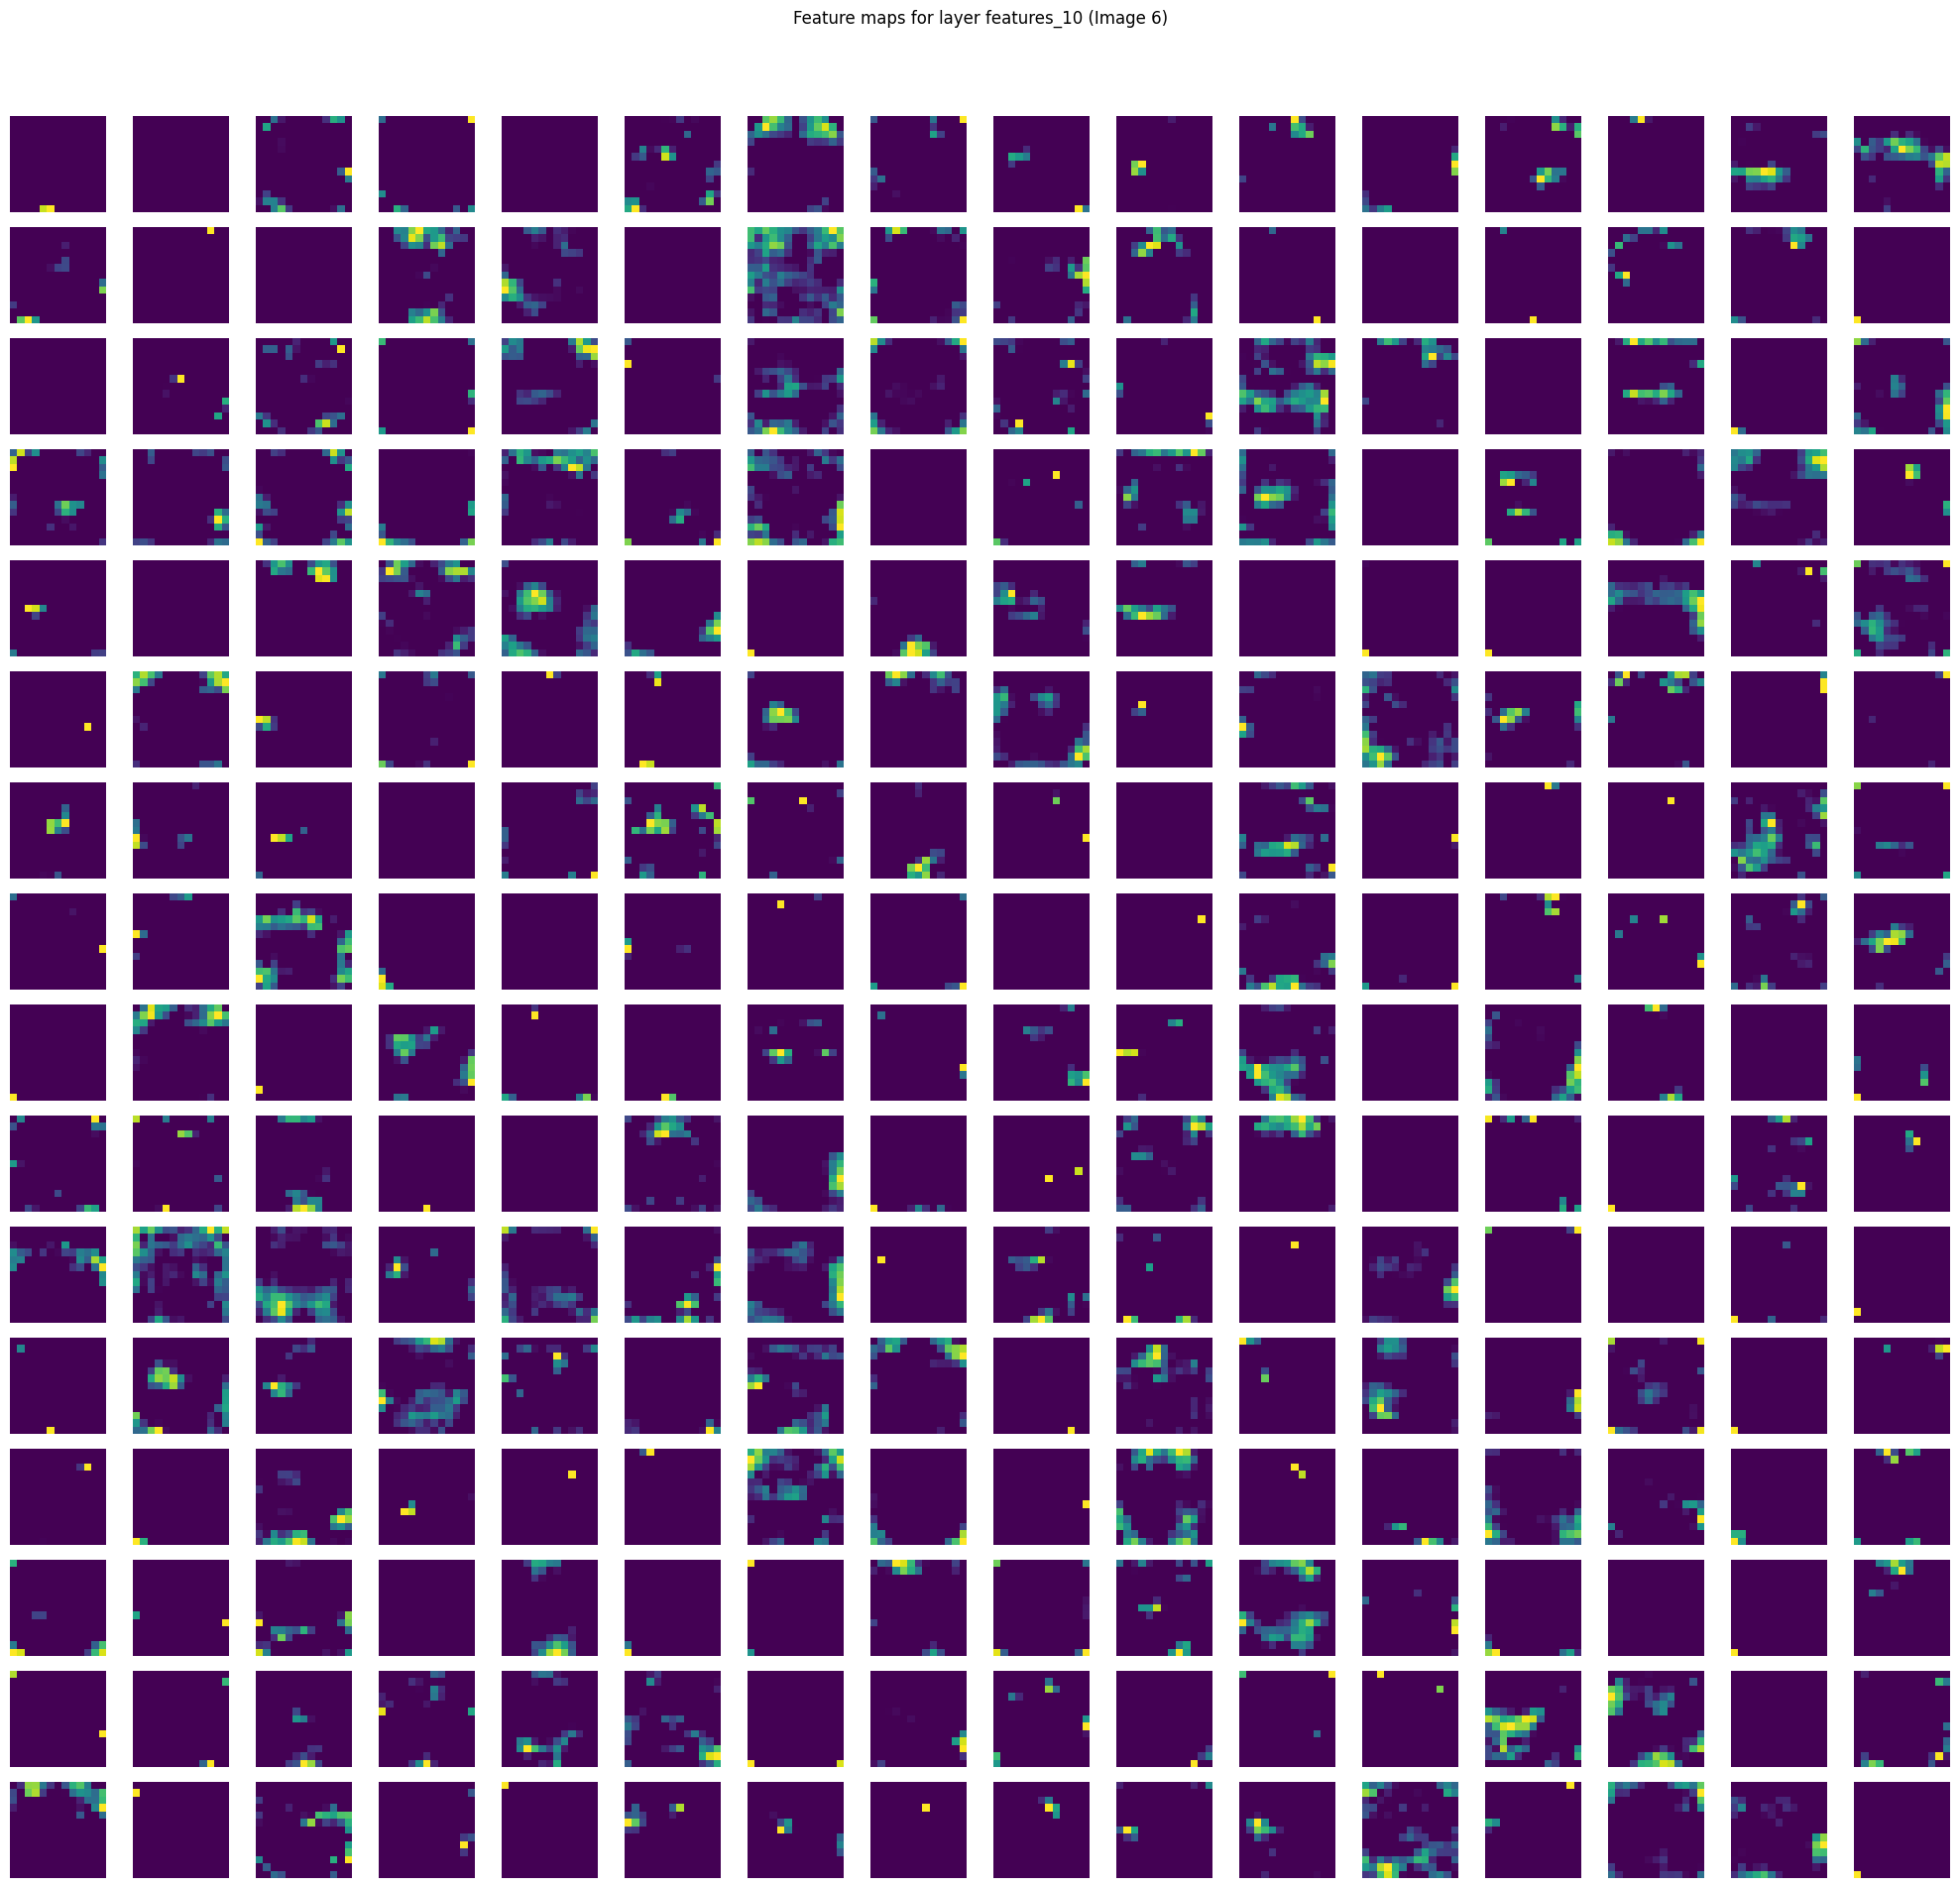

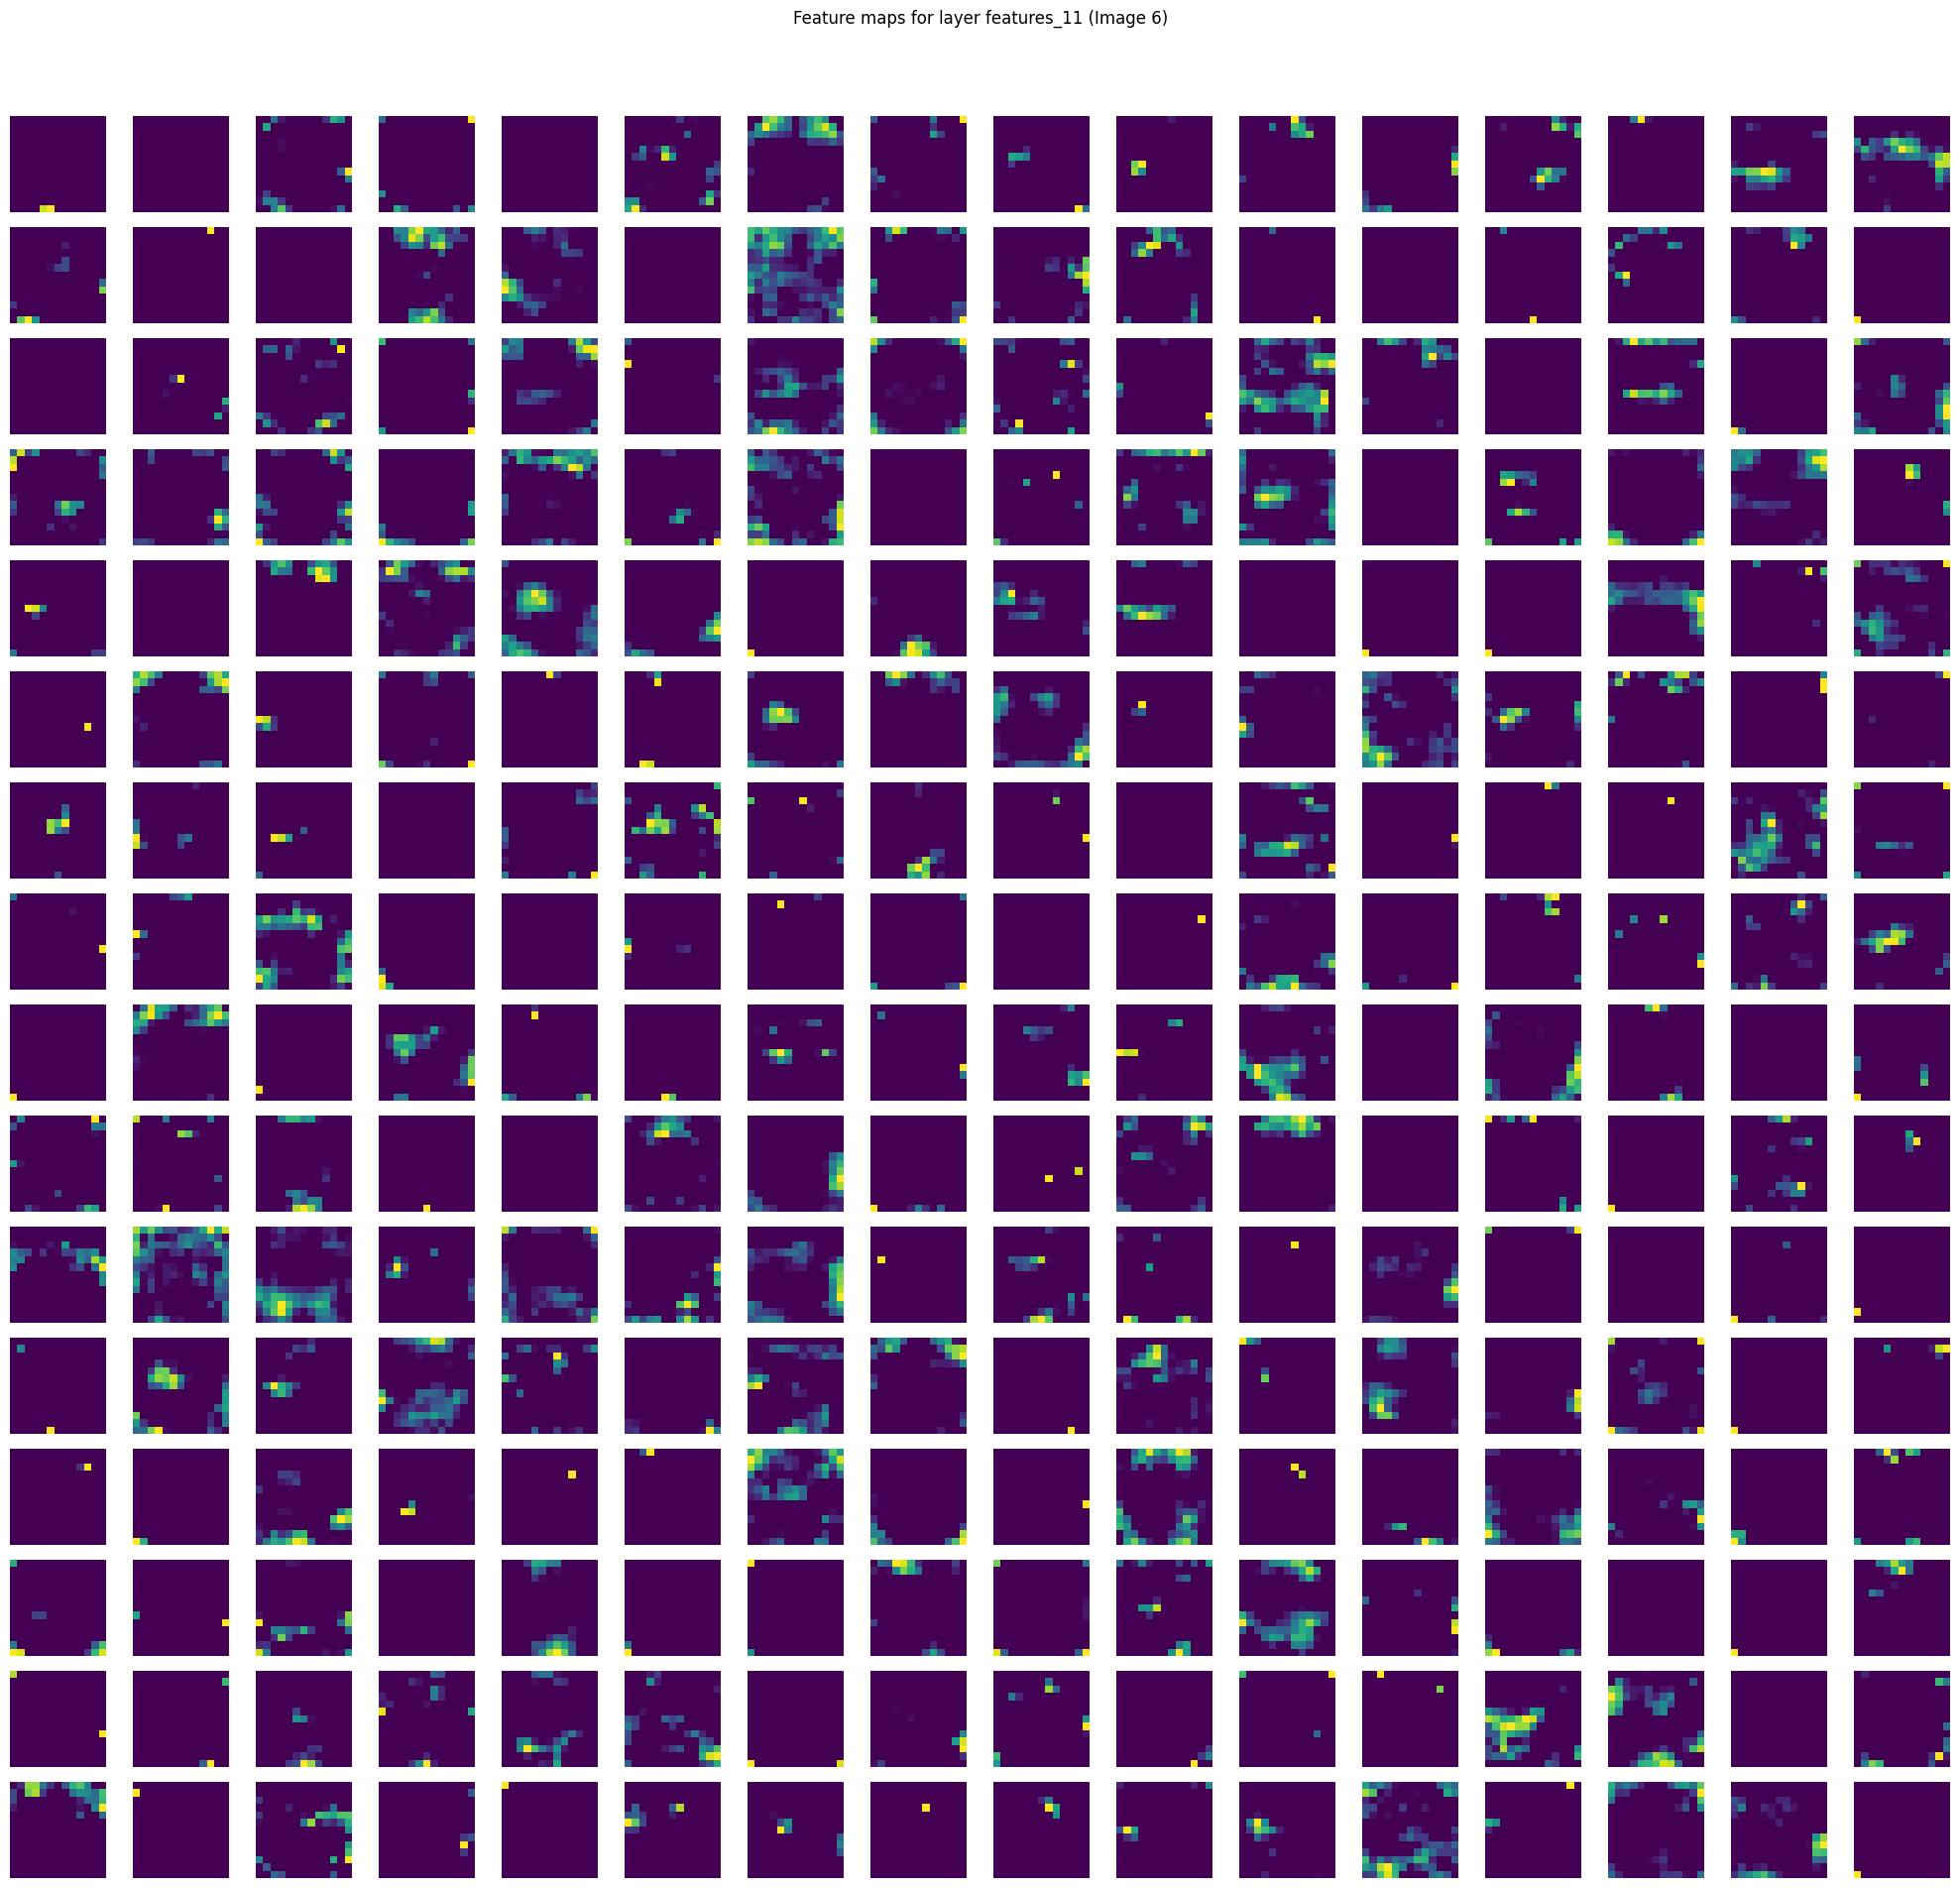

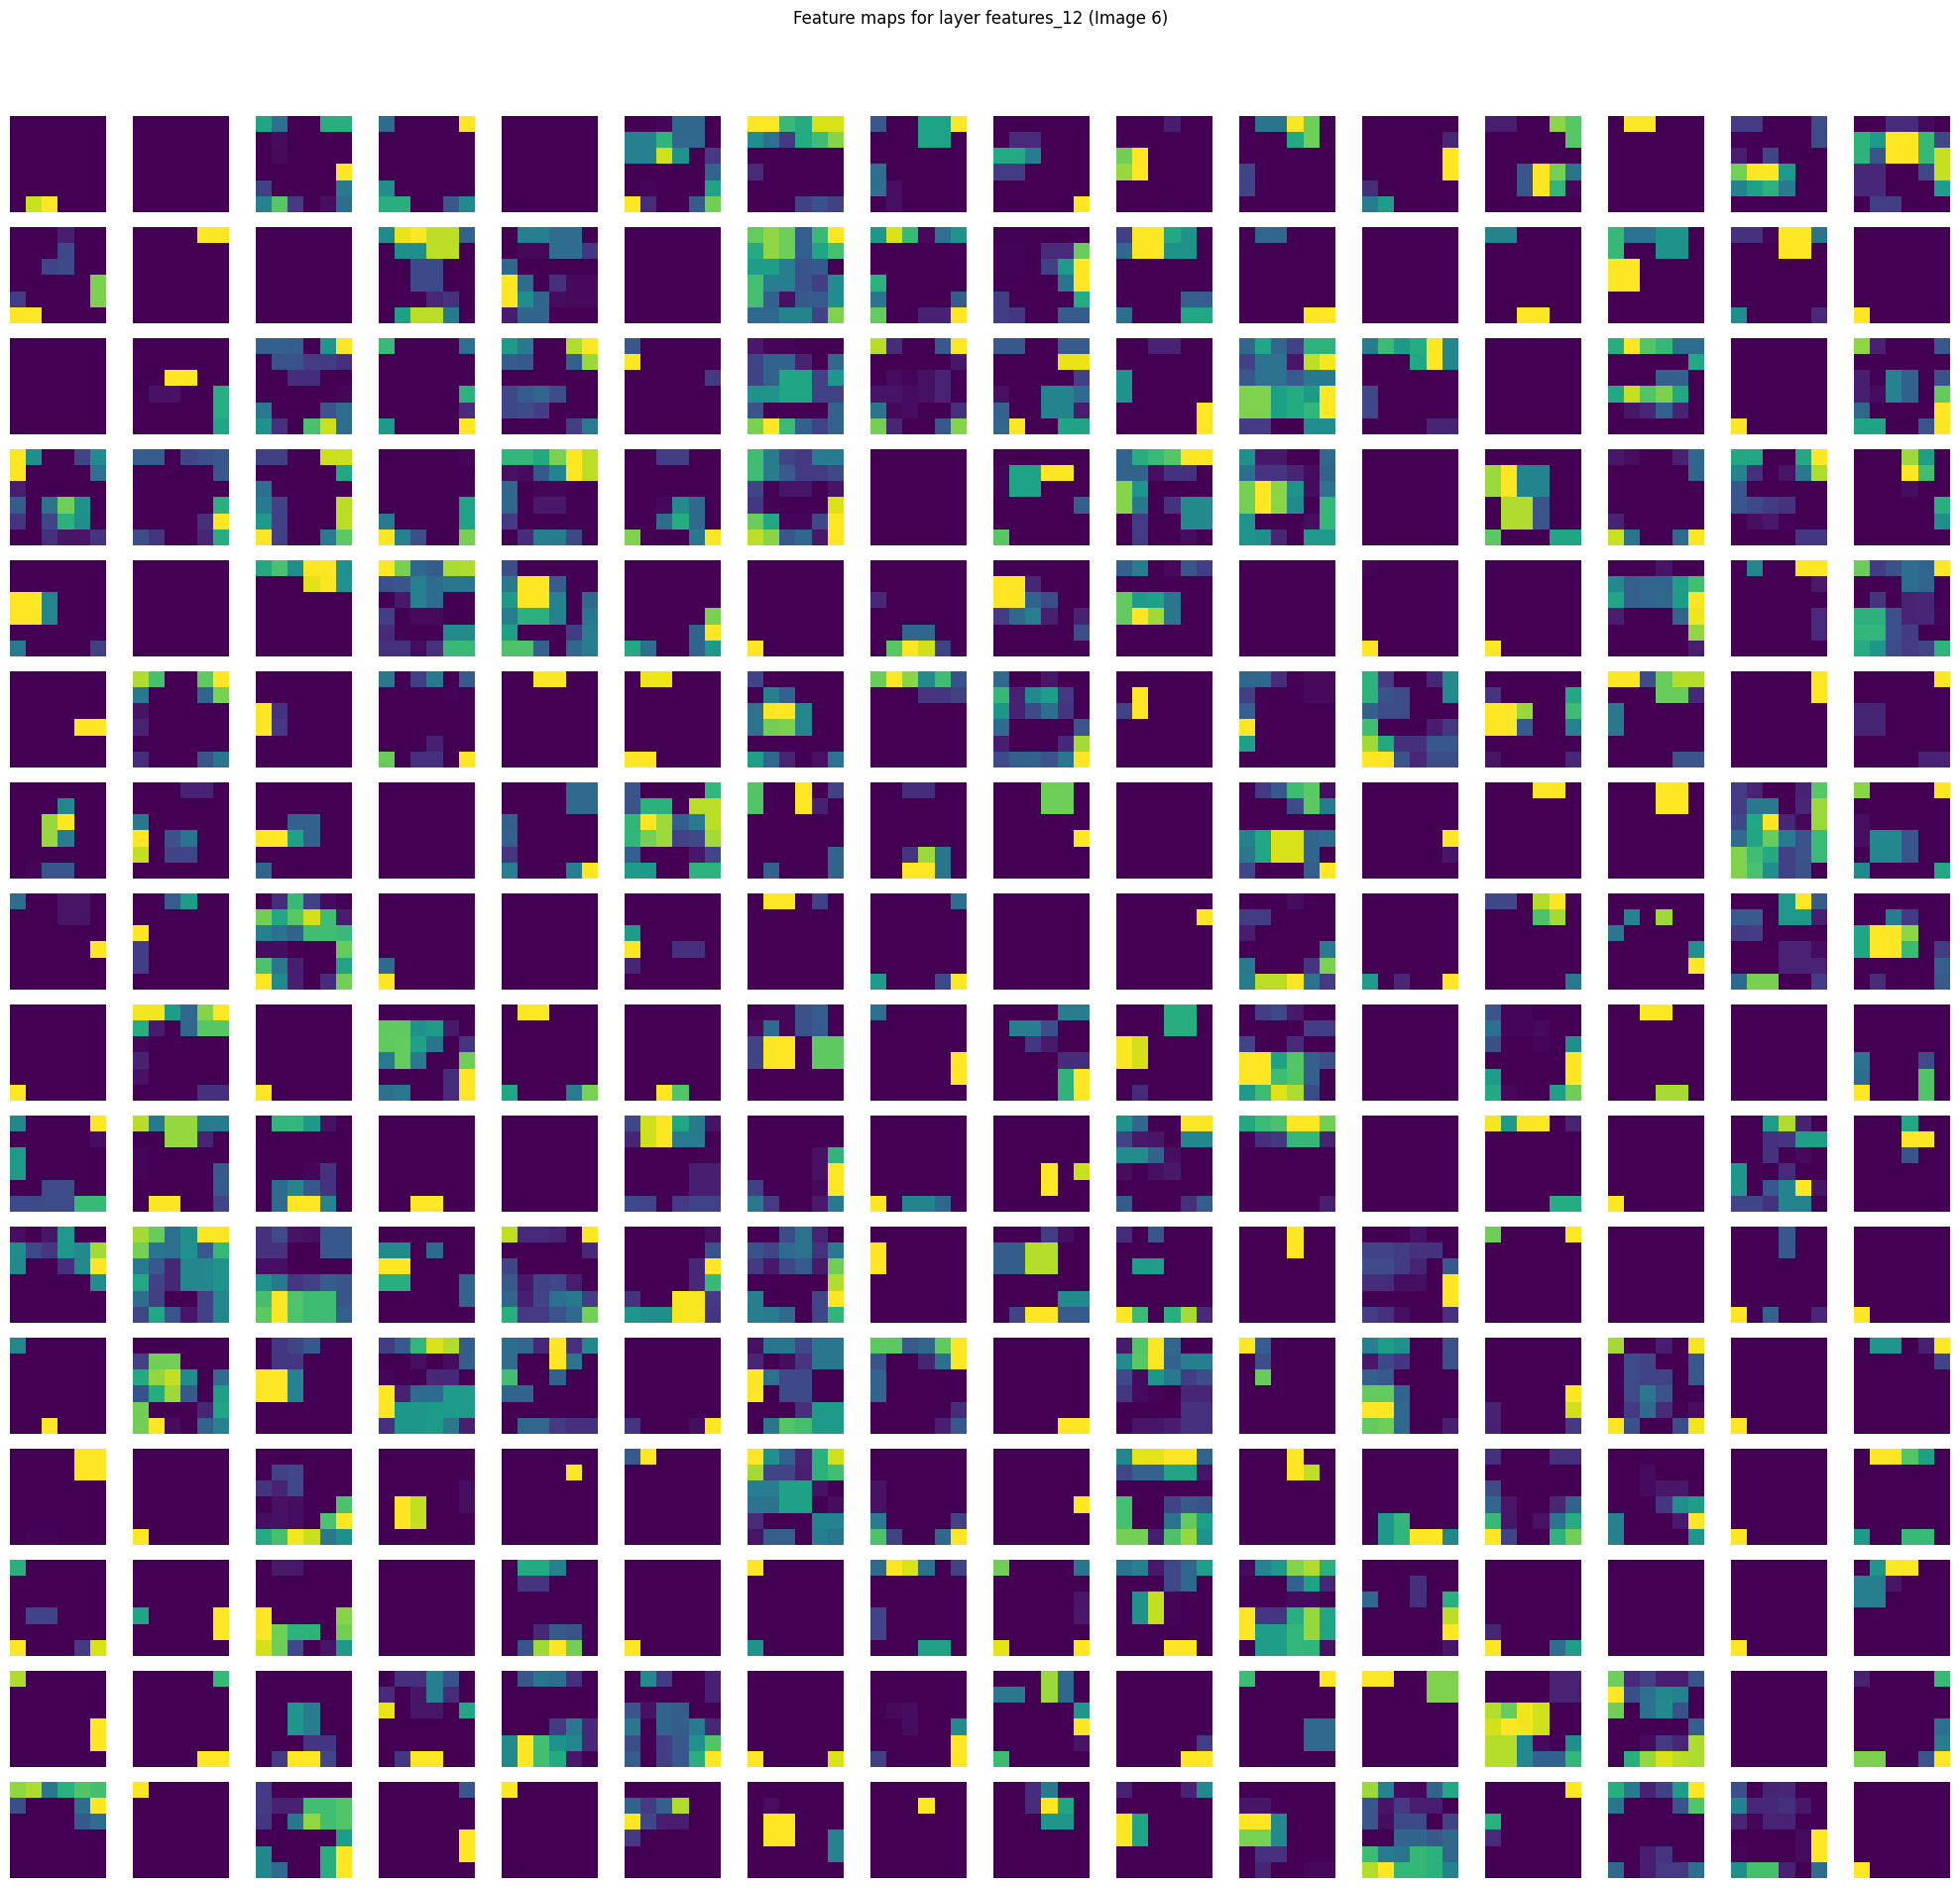

In [17]:
def visualize_activations(intermediate_outputs, image_idx=0):
    # Convert the 3-channel grayscale image back to a single-channel grayscale image
    # by taking one of the duplicated channels (e.g., the first channel)
    img = test_inputs[image_idx][0]  # Taking the first channel
    plt.imshow(img, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    plt.show()

    for layer_name, activation in intermediate_outputs.items():
        if 'classifier' in layer_name:
            # Classifier activations do not have spatial dimensions that can be visualized as images
            continue

        # Assuming the activation is a 4D tensor: [batch_size, num_feature_maps, height, width]
        num_feature_maps = activation.size(1)
        
        # Determine the grid size square that is large enough to display all feature maps
        grid_size = int(np.ceil(np.sqrt(num_feature_maps)))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))

        for i in range(grid_size ** 2):
            ax = axes[i // grid_size, i % grid_size]
            if i < num_feature_maps:
                # Extract the i-th feature map for the specified image index in the batch
                feature_map = activation[image_idx, i].detach().cpu().numpy()
                ax.imshow(feature_map, cmap='viridis')
            ax.axis('off')
        
        plt.suptitle(f'Feature maps for layer {layer_name} (Image {image_idx})')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

image_idx = 6  # Change this to the index of the image you want to visualize
visualize_activations(intermediate_outputs, image_idx=image_idx)
